# Week 1 Iceclassic Content and Plots

## Importing files and selecting the datasets that we will use


In [1]:
import pandas as pd
from datetime import time ,datetime,timedelta
import pprint # for printing dictionaries
import matplotlib.pyplot as plt
from funciones import*


#Break up dates list
dates = pd.read_csv('../../data/List_break_up_dates.csv',names=['date_time'],header=None)
dates['date_time']=pd.to_datetime(dates['date_time'])


# External Variables
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
# Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 
# selected_cols=['Regional: Air temperature [C]','Nenana: Rainfall [mm]','Nenana: Snowfall [mm]','Nenana: Mean Discharge [m3/s]','IceThickness [cm]']
# Data=Data[selected_cols]


In [2]:
Gage=pd.read_csv('../../data/raw_files/Nenana_Gage.txt',skiprows=24,sep='\t')
Gage['datetime'] = pd.to_datetime(Gage['datetime'])
Gage_mean= Gage.groupby(Gage['datetime'].dt.date)['1832_00065'].mean().reset_index()


Gage_mean.rename(columns={'datetime': 'date'}, inplace=True)
Gage_mean['Nenana: Gage Height [m]'] = Gage_mean['1832_00065'] * 0.3048
Gage_Height = Gage_mean[['date', 'Nenana: Gage Height [m]']]
Gage_Height.set_index('date', inplace=True)

df_merged = Data.merge(Gage_Height, left_index=True, right_index=True, how='left')

df_merged.to_csv('../../data/Time_series_DATA_Gage_Height.csv',sep='\t')
df_merged.index = pd.to_datetime(df_merged.index, format="%Y-%m-%d")
print(df_merged)

# explore_contents(df_merged)



            Regional: Air temperature [C]  Days since start of year  \
1901-02-01                            NaN                       NaN   
1901-03-01                            NaN                       NaN   
1901-04-01                            NaN                       NaN   
1901-05-01                            NaN                       NaN   
1901-06-01                            NaN                       NaN   
...                                   ...                       ...   
2024-02-02                            NaN                       NaN   
2024-02-03                            NaN                       NaN   
2024-02-04                            NaN                       NaN   
2024-02-05                            NaN                       NaN   
2024-02-06                            NaN                       NaN   

            Days until break up  Nenana: Rainfall [mm]  Nenana: Snowfall [mm]  \
1901-02-01                  NaN                    NaN            

## 1. Use dictionaries to store dataset metadata and information about break-up years

We use `groupby-apply-tranform` in variables from `Data`(df with all the data) to collapse a year of data to a single value per year, then re-index to align.

In [3]:
# creating a dictionary for every break up date, then creating a dictionary with the dictionaries
dates = pd.read_csv('../../data/List_break_up_dates.csv',names=['date_time'],header=None)
dates['date_time']=pd.to_datetime(dates['date_time'])




#=========================================================================================#
#  keys related to break_up dates 
#=========================================================================================#
dates['year']=dates['date_time'].dt.year
dates['month']=dates['date_time'].dt.strftime('%B')
dates['day']=dates['date_time'].dt.day
dates['day_of_year']=dates['date_time'].dt.dayofyear

dates.index=dates['year']

dates['days_since_01_apr']=dates['date_time'].apply(lambda dt : (dt-pd.Timestamp(year=dt.year,month=4,day=1)).days)
dates['time']=dates['date_time'].dt.time
dates['hour']=dates['date_time'].dt.hour
dates['minute']=dates['date_time'].dt.minute

dates['decimal_time']=round(dates['date_time'].dt.time.apply(lambda t: decimal_time(t,direction='to_decimal')),4)
dates['decimal_day_of_year']=round(dates['time'].apply(lambda t: decimal_day(t,direction='to_decimal'))+dates['day_of_year'],8)
# decimal day
# decimal year, etc


#=========================================================================================#
#  keys related to ice_thickness 
#=========================================================================================#
Ice=Data['IceThickness [cm]'].dropna()  # to make the following lines cleaner
dates['max_ice_thickness'] =Ice.groupby(Ice.index.year).max().reindex(dates.index,method=None)
dates['day_of_max_ice_thickness']=Ice.groupby(Ice.index.year).idxmax().reindex(dates.index,method=None)
dates['last_ice_measurement']=Ice.groupby(Ice.index.year).last().reindex(dates.index,method=None)
dates['day_of_last_ice_measurement']=Ice.groupby(Ice.index.year).apply(lambda x: x.index[-1]).reindex(dates.index,method=None)

dates['n_days_last_measured_ice_&_break_up']=dates.apply( lambda row: (row['day_of_last_ice_measurement']-row['date_time']).days if pd.notna(row['day_of_last_ice_measurement']) and pd.notna(row['date_time']) else None,axis=1)



dates['final_melting_gradient[cm/day]']=Ice.groupby(Ice.index.year).apply(lambda x: (x.iloc[-2]-x.iloc[-1])/(x.index[-2]-x.index[-1]).days).round(3).reindex(dates.index,method=None)
# if we define that break up happens wiht ice thickness equal to zero, the final melting gradient would be computed diffentle, but not always the break-up happens when the thickness is zero.
dates['melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]']=round(dates['last_ice_measurement']/dates['n_days_last_measured_ice_&_break_up'],3)
#=========================================================================================#
#  keys related to temperature
#=========================================================================================#
Temp=Data['Regional: Air temperature [C]'].dropna()
dates['days_over_minus_2'] = Temp.groupby(Temp.index.year).apply(lambda x: (x > -2).sum()).astype(int).reindex(dates.index,method=None) # assumes that the number of day over 1 since the start of ice formation to jan 01 is zero 
dates['cumsum_over_2_temp']= Temp.groupby(Temp.index.year).apply(lambda x: x.clip(lower=0).where(x > 2).sum()).round(3).reindex(dates.index,method=None)
dates['avg_temp']=Temp.groupby(Temp.index.year).mean().round(2)
# min tem, max temp, min tem in jan, etc

#=========================================================================================#
#  converting df to dict of dict and list of dict 
#=========================================================================================#

# print('Printing Dataframe\n=====================')
# print(dates)

dict_of_dict=dates.to_dict(orient='index')
#print('Printing dict of dict\n=====================')
#pprint.pprint(dict_of_dict,sort_dicts=False) # to avoid PrettyPrint printing the keys alphabetically


# list_of_dict=dates.to_dict(orient='records')
# print('Printing list of dict\n=====================')
# pprint.pprint(list_of_dict,sort_dict-False)


#=========================================================================================#
#  accessing element of dict_of_dict
#=========================================================================================#
# because we assigned the year to each dict we can simply pass the year to get the data related to the break up of that year
pprint.pprint(dict_of_dict[2015],sort_dicts=False)  

{'date_time': Timestamp('2015-04-24 14:25:00'),
 'year': 2015,
 'month': 'April',
 'day': 24,
 'day_of_year': 114,
 'days_since_01_apr': 23,
 'time': datetime.time(14, 25),
 'hour': 14,
 'minute': 25,
 'decimal_time': 14.4167,
 'decimal_day_of_year': 114.60069444,
 'max_ice_thickness': 97.79,
 'day_of_max_ice_thickness': Timestamp('2015-03-05 00:00:00'),
 'last_ice_measurement': 85.09,
 'day_of_last_ice_measurement': Timestamp('2015-04-06 00:00:00'),
 'n_days_last_measured_ice_&_break_up': -19.0,
 'final_melting_gradient[cm/day]': -1.27,
 'melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]': -4.478,
 'days_over_minus_2': 219.0,
 'cumsum_over_2_temp': 1754.84,
 'avg_temp': -0.77}


## 2. Datasets are stored as a dictionary of dictionaries:


In [4]:
variable_summary={}

n_total=len(Data.index.year.unique())
print(n_total)

for column in Data.columns:
    first_obs=Data.index.year.min()
    last_obs=Data.index.year.max()
    avg_n_obs_yearly=Data[column].groupby(Data.index.year).count().mean().round(2)
    historic_max=Data[column].max().round(2)
    yearly_avg=Data[column].mean().round(2)
    n_years=Data[Data[column].notna()].index.year.unique()
    n_year_percent=round((len(n_years)/n_total*100),2)
    variable_summary[column]={
        'year_start':first_obs,
        'year_end':last_obs,
        'avg_n_yearly': avg_n_obs_yearly,
        'historic_max': historic_max,
        'yearly_avg': yearly_avg,
        'years_present (%)':n_year_percent,
        'years_present':n_years}
    


pprint.pprint(variable_summary['Regional: Air temperature [C]'],sort_dicts=False)


124
{'year_start': 1901,
 'year_end': 2024,
 'avg_n_yearly': 310.99,
 'historic_max': 23.23,
 'yearly_avg': -2.61,
 'years_present (%)': 85.48,
 'years_present': Index([1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       ...
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int32', length=106)}


>To get more info we can always use the function `explore_contents` from the iceclassic package, more ways to visualize the contents can be seen in the book section `Loading_&_Exploring_Data.ipynb`, like the interactive plots and the timeseries plots/distribution of each variable/column


## 3. Time Series Plots

#### 3.1/3.2/3.3 Plotting, labels and highlighting years
We will use a slightly updated version from the function `plot_contents` from the iceclassic package, the updated version can be found in `/funciones.py`, and has not been 
committed/uploaded to its individual repo nor released to PyPi
\


More examples on how to use the function can be found in the book in the section `Seasonality(groupby-transform-apply).ipynb`

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39081 entries, 1917-01-01 to 2023-12-31
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29516 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22525 non-null  float64
 8   Nenana: Air temperature [C]                        31146 non-null  fl

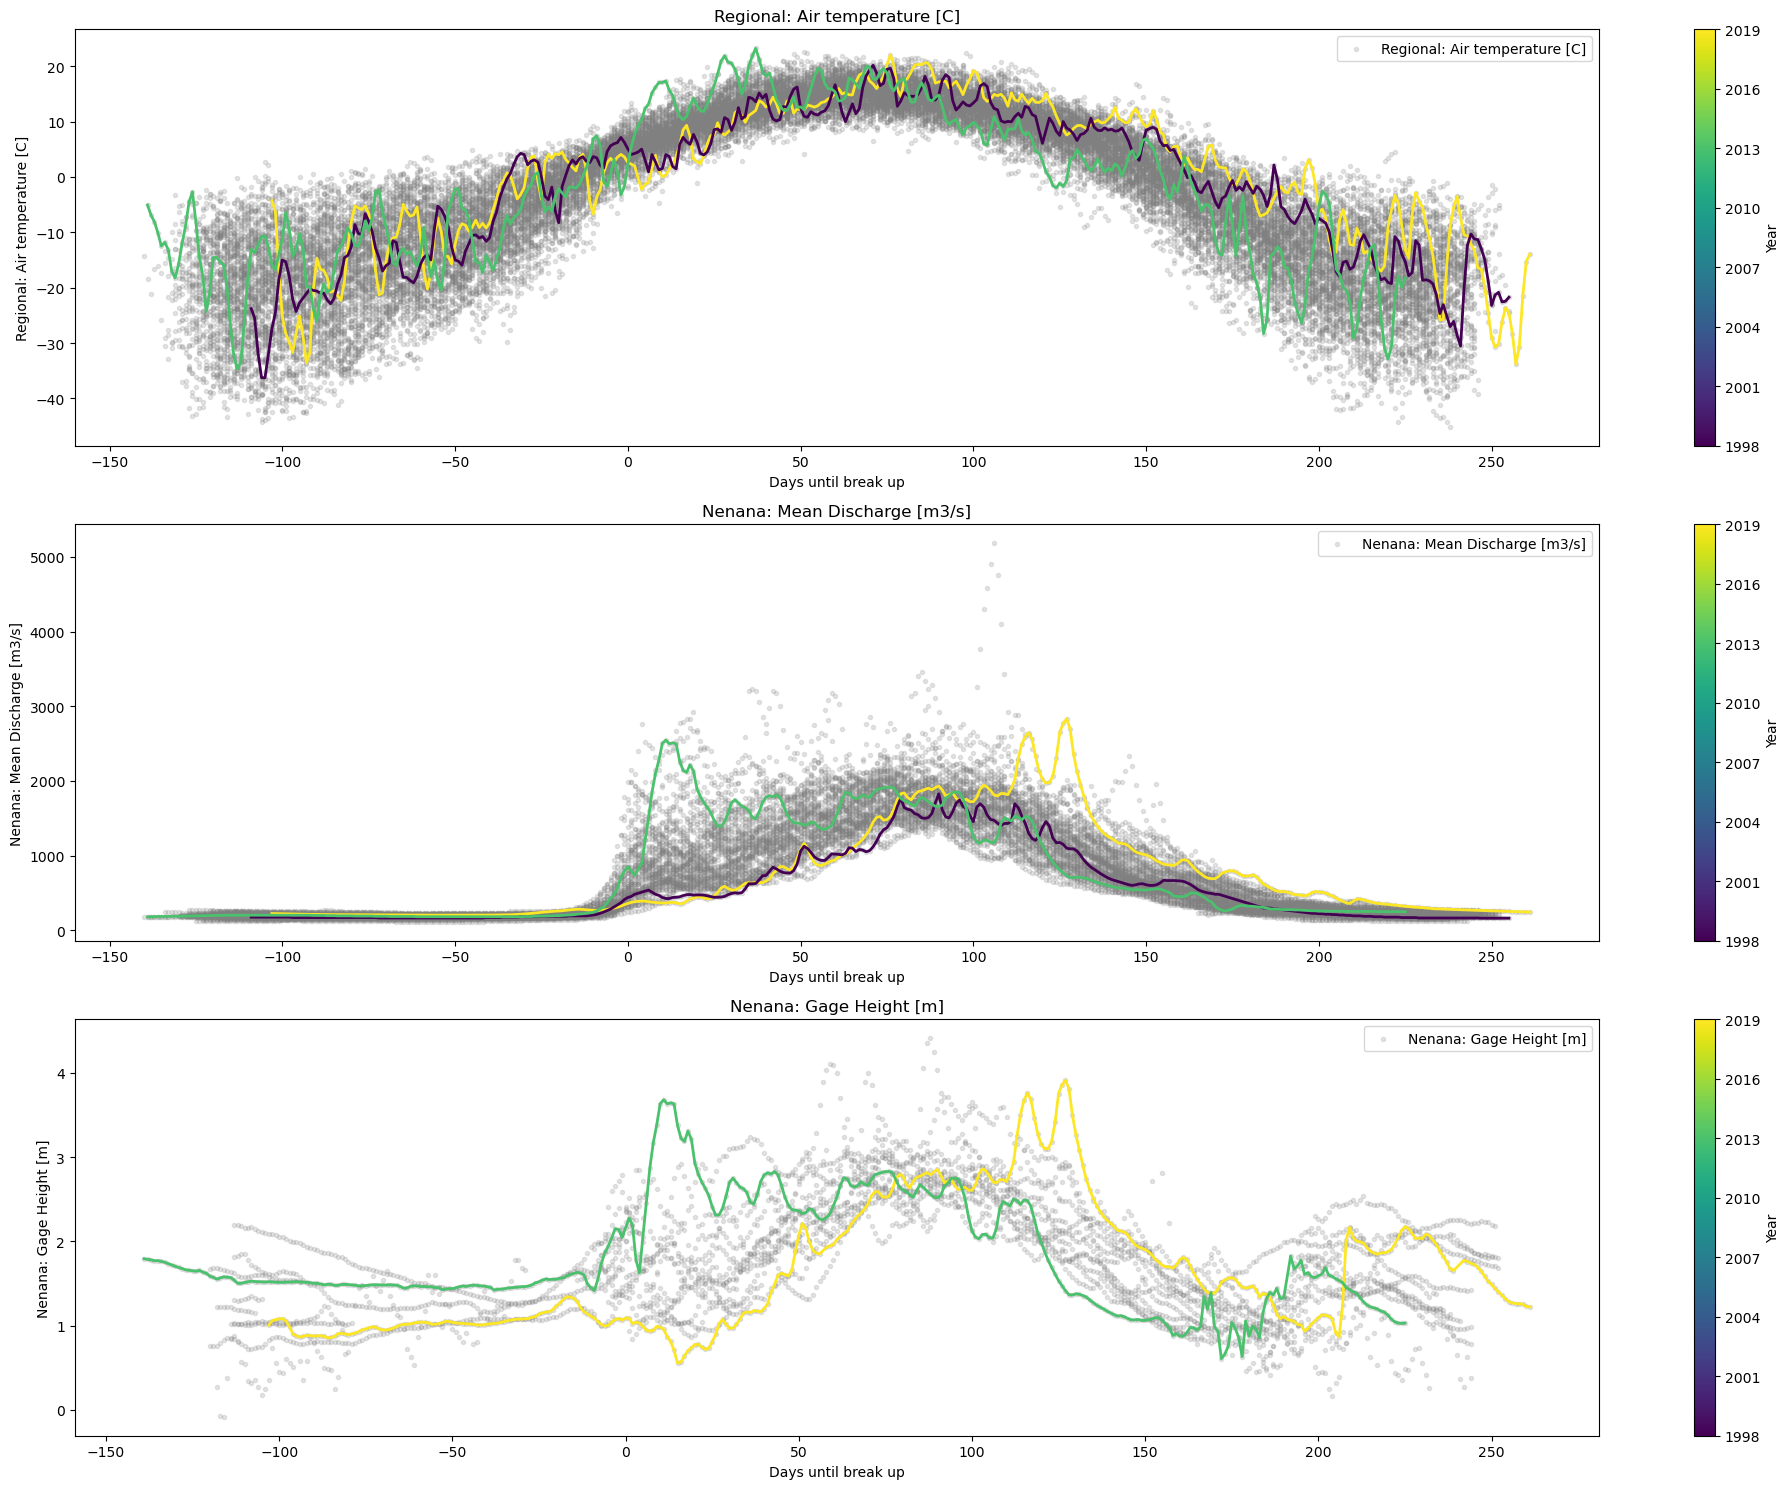

In [5]:


# we reload df cuz we need some column that we dropped at the beginning
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 
Data.info()

plot_contents(df_merged,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]','Nenana: Gage Height [m]'],     # what columns to plot, default all
              col_cmap=['grey'],                                     # list of colors for each column, default is sequential cmap, but list of colors can be passed as well
              scatter_alpha=0.2,                                     # we can 'mute' the scatter points if we choose lapha=0, then the col_map is irrelevant, cuz the scatter markers are no being plotted
              plot_mean_std=False,                                   # we 'mute' the baseline across all years, similar here, if it were 'True' the color would have been grey' 
              multiyear=[2019,1998,2013],                            # we select which years to highlight
              years_line_width=2,                                    # change the iwth of line if necessary
              plot_break_up_dates=True,
              xaxis='Days until break up')                              # plotting break_up_dates makers with annotations, default =False 

 
> fix,  move scatter point to the front of plot, add arrows between the label and the point.

the argument  `xlim` can be passe to restrict the xaxis

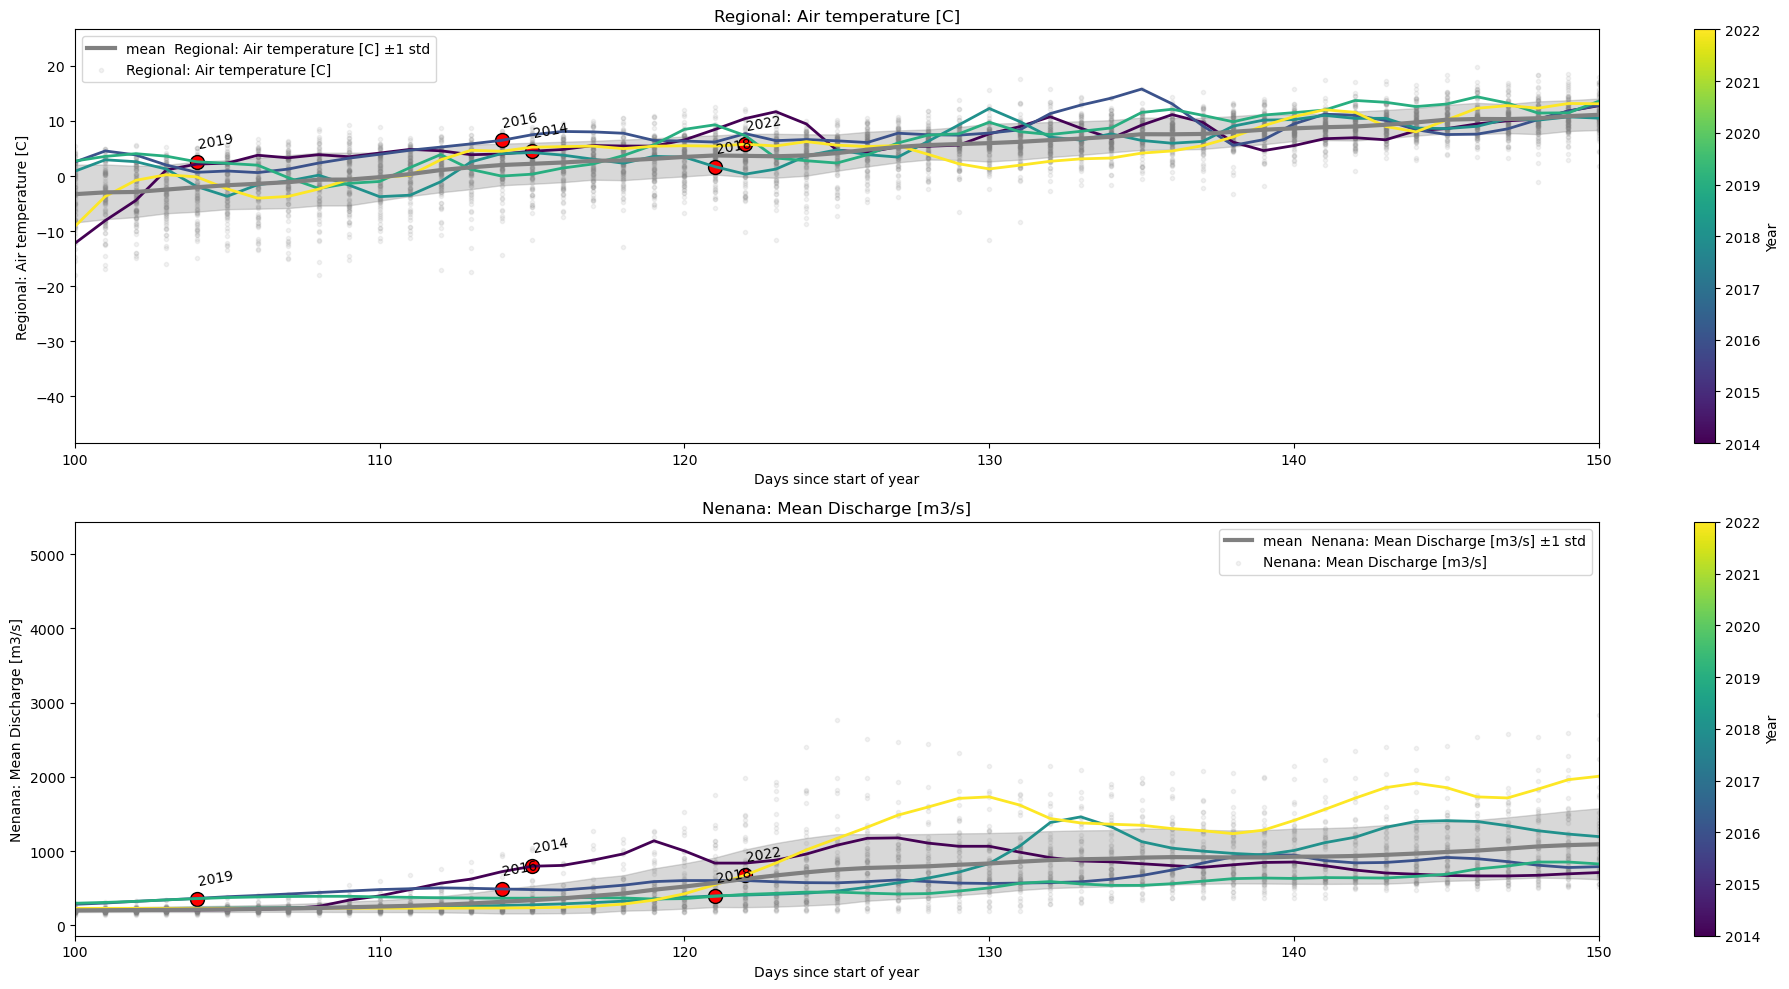

In [6]:
from funciones import*

# we reload df cuz we need days to breal up and days of year colums
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 

plot_contents(df_merged,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],    # what column to plot, default all
              col_cmap=['grey'],                                    # list of colors for each column, default is sequential cmap
              scatter_alpha=0.1,                                    # we 'mute' the scatter points
              plot_mean_std=True,                                   # now we plot the baseline across all years
              multiyear=[2014,2016,2018,2019,2022],                 # we select which years to choose
              plot_break_up_dates=True,                             # plotting break_up_dates scatter default =False 
              years_line_width=2,                                   # line with a litlte bit narrower than dafault=4
              xlim=[100,150])                                       # xlimits

### 3.4 Normalizing x-axis

The easiest way to normalize xaxis is by choosing xaxis='Days until break up' ( which is a column in Data).

With this axis, there is no need to put annotations with the year, because we know that data is normalized such that the breakup happens at xaxis=0.


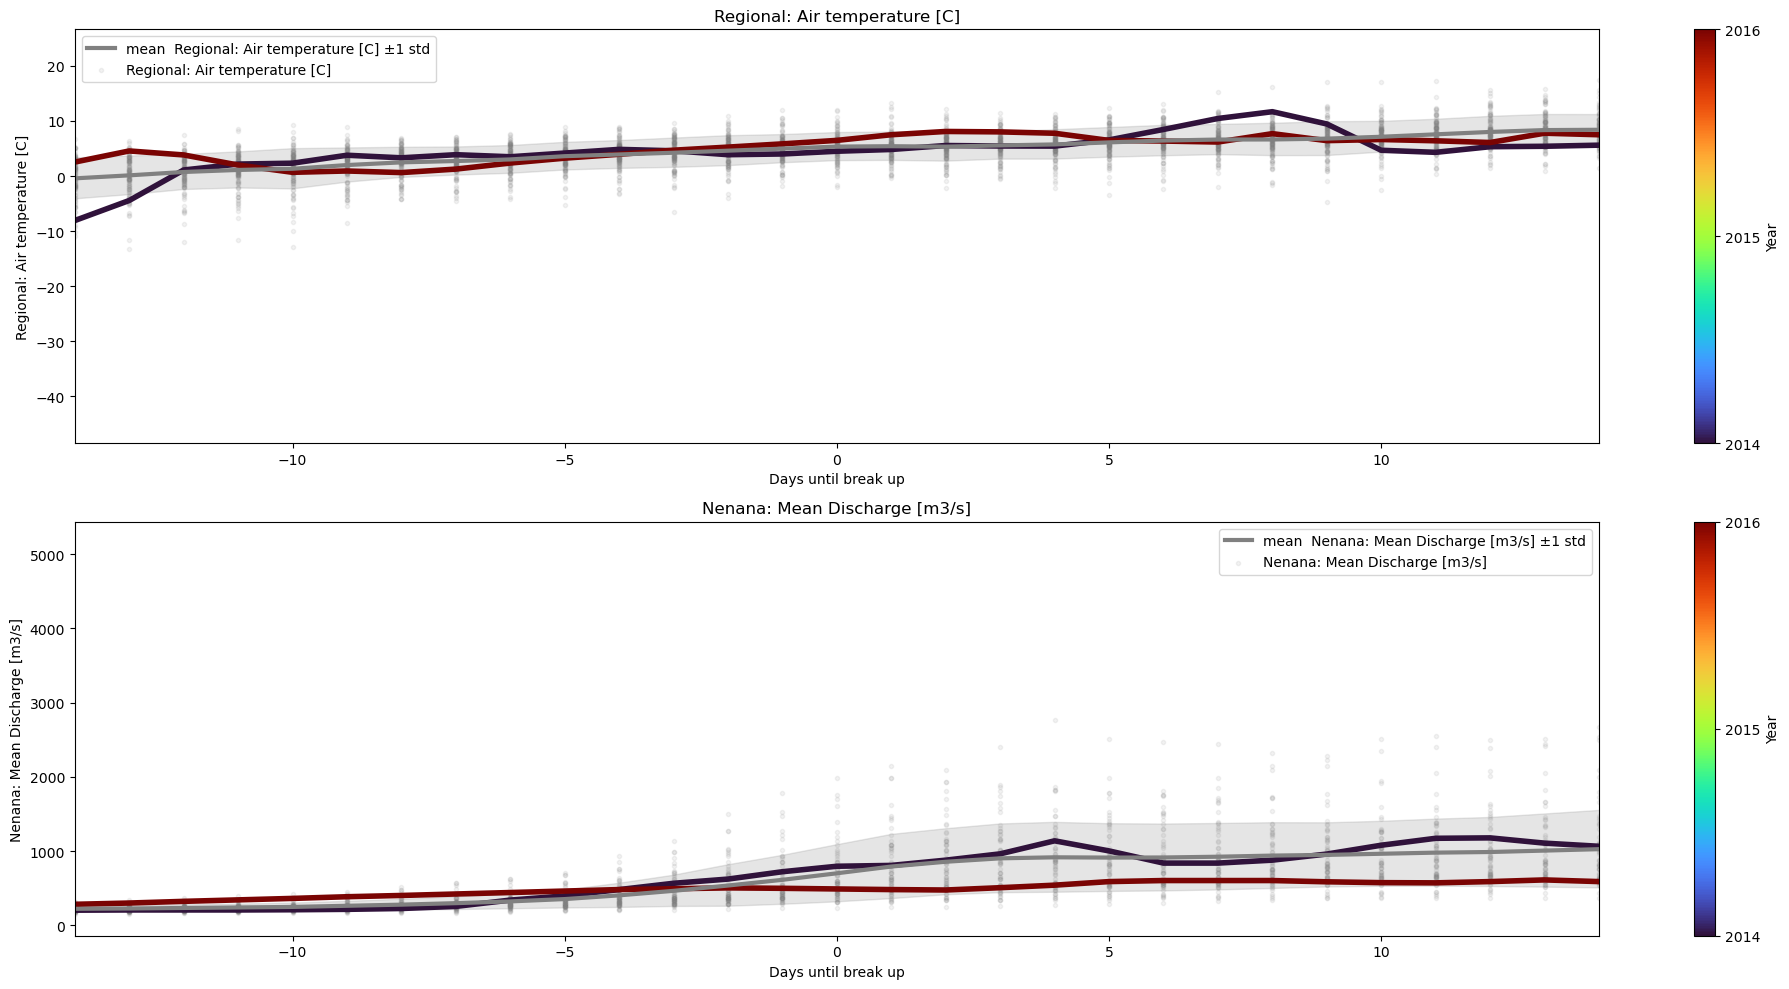

In [7]:
plot_contents(Data,
              xaxis='Days until break up',
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],    # what column to plot, default all
              col_cmap=['grey'],                                    # list of colors for each column, default is sequential cmap
              std_alpha=0.2,                                        # alpha for the fill
              plot_mean_std=True,                                   # if we put true the baseline plus scatter are plotted
              multiyear=[2014,2016],                                # we select which years to choose
              plot_break_up_dates=True,                             # plotting break_up_dates scatter default
              xlim=[-14,14],
              years_cmap='turbo')                                   # we can pass other cmaps for the colorbar

## 4. Scatter Plots

 Because the df/dict is already aligned, we can easily access and plot stuff.

We can use any of the column of `dates` as either x or y vectors.

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 1917 to 2023
Data columns (total 21 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   date_time                                                      107 non-null    datetime64[ns]
 1   year                                                           107 non-null    int32         
 2   month                                                          107 non-null    object        
 3   day                                                            107 non-null    int32         
 4   day_of_year                                                    107 non-null    int32         
 5   days_since_01_apr                                              107 non-null    int64         
 6   time                                                           107 non-null    object        
 7   

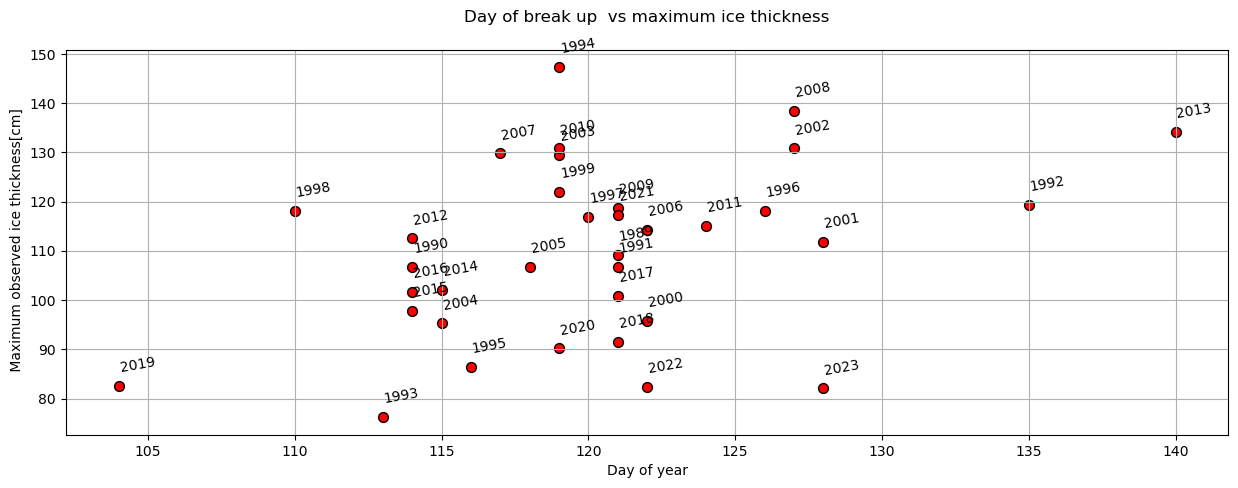

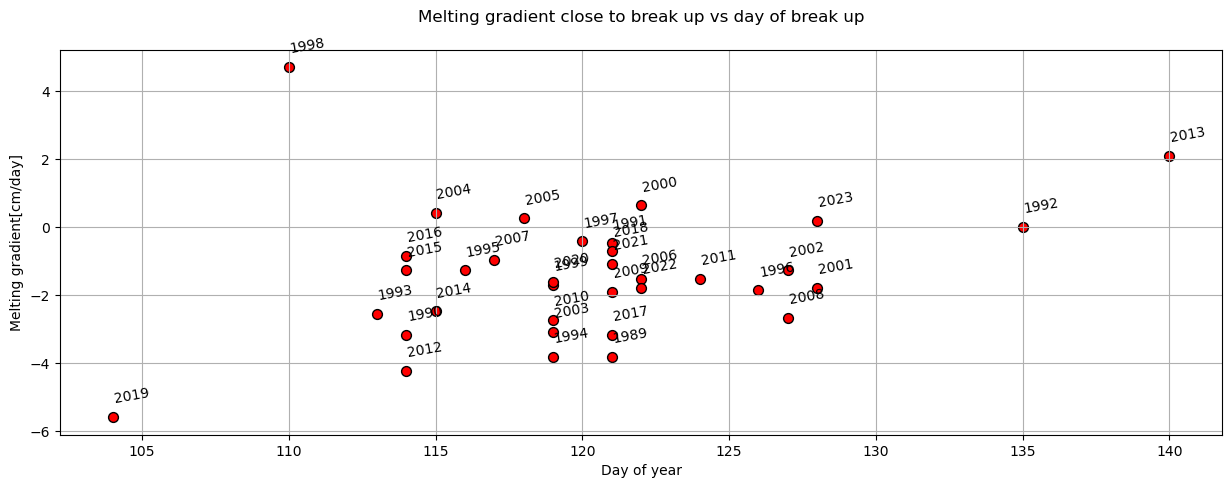

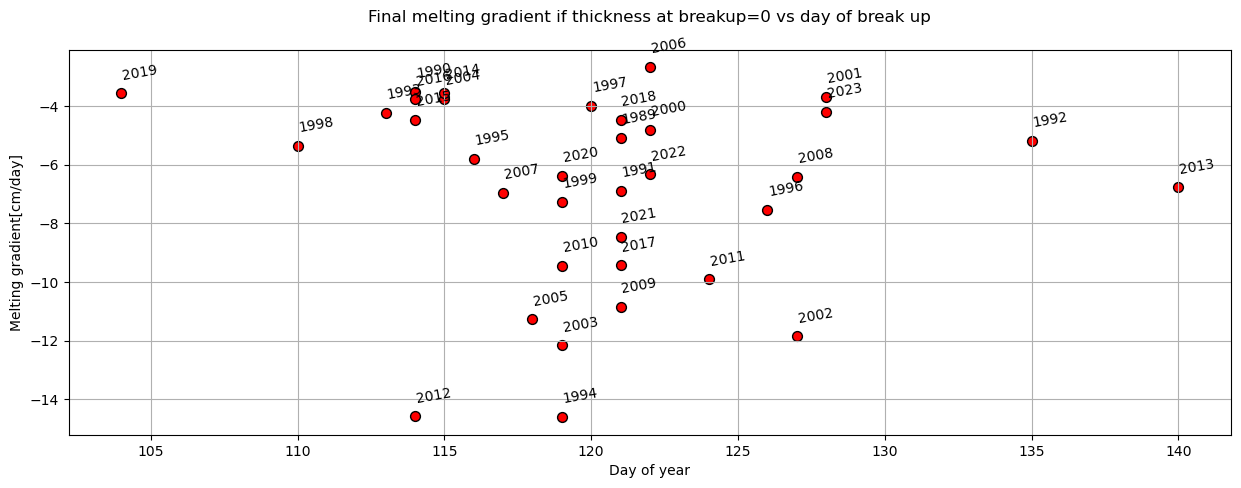

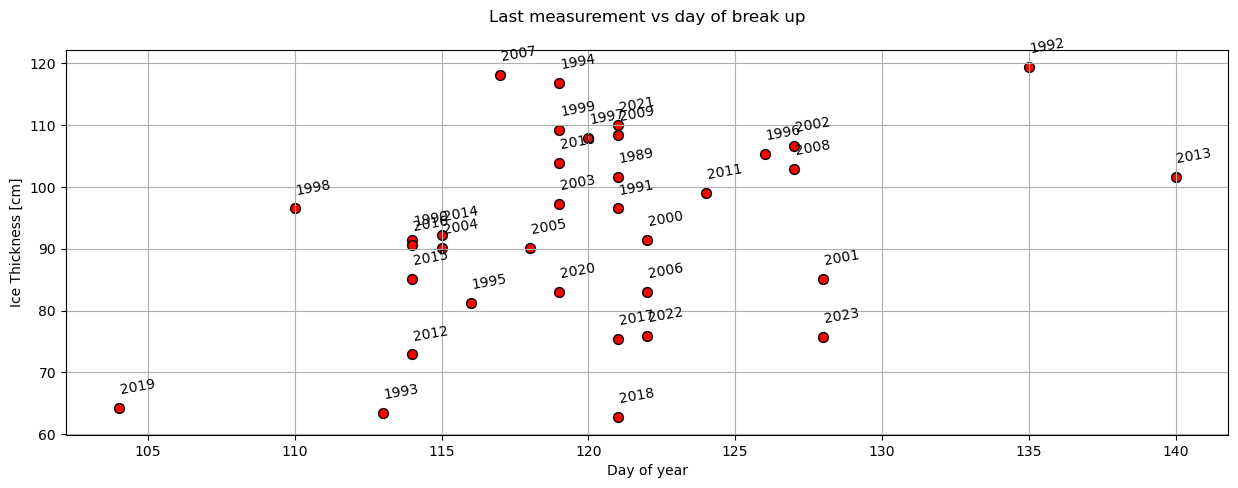

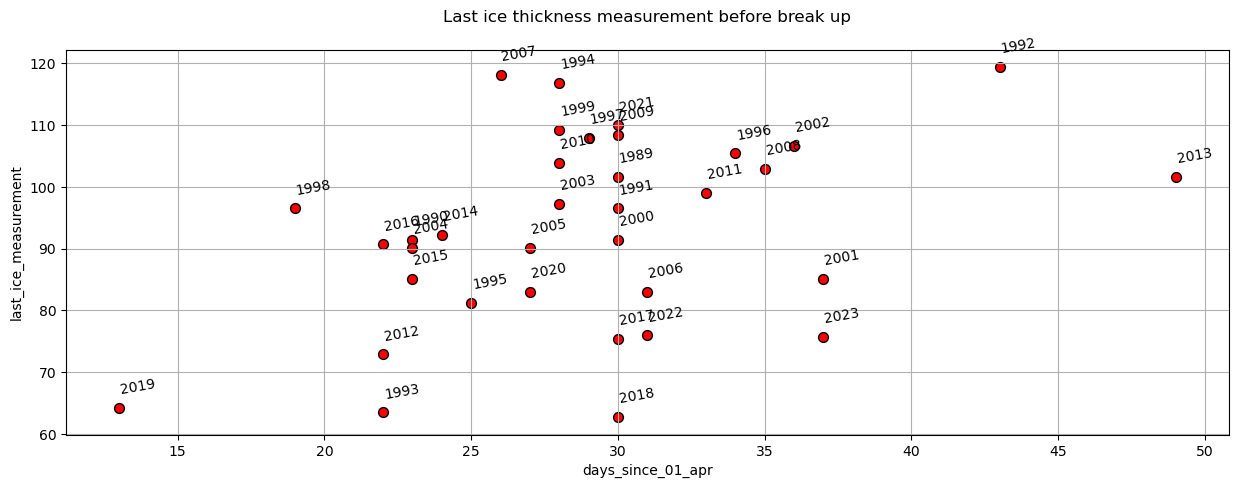

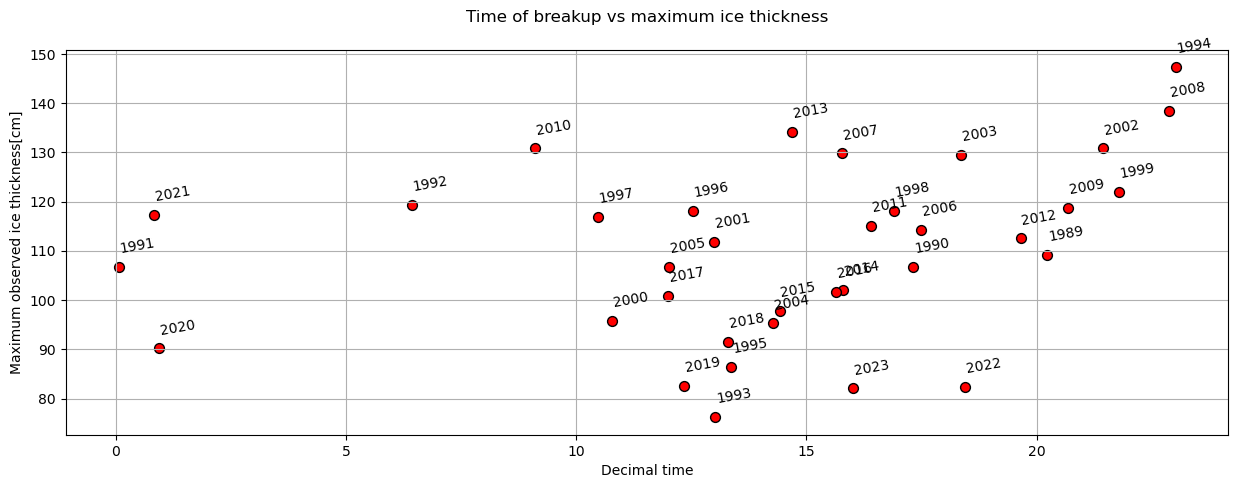

In [8]:
dates.info()

plot_scatter(dates,'day_of_year','max_ice_thickness',x_label='Day of year',y_label=' Maximum observed ice thickness[cm]',title='Day of break up  vs maximum ice thickness')
plot_scatter(dates,'day_of_year','final_melting_gradient[cm/day]',x_label='Day of year',y_label='Melting gradient[cm/day]',title='Melting gradient close to break up vs day of break up')
plot_scatter(dates,'day_of_year','melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]',x_label='Day of year',y_label='Melting gradient[cm/day]',title='Final melting gradient if thickness at breakup=0 vs day of break up')
plot_scatter(dates,'day_of_year','last_ice_measurement',x_label='Day of year',y_label='Ice Thickness [cm]',title='Last measurement vs day of break up')
plot_scatter(dates,'days_since_01_apr','last_ice_measurement',title='Last ice thickness measurement before break up')
plot_scatter(dates,'decimal_time','max_ice_thickness',x_label='Decimal time',y_label='Maximum observed ice thickness[cm]',title='Time of breakup vs maximum ice thickness')



# Other plots
Examples of other plots that we can make withe de function that we have.



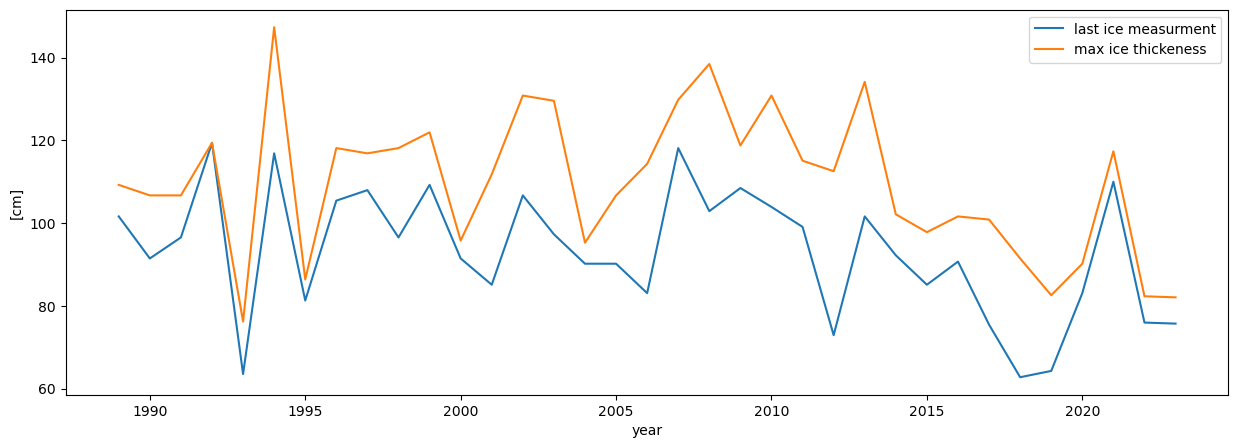

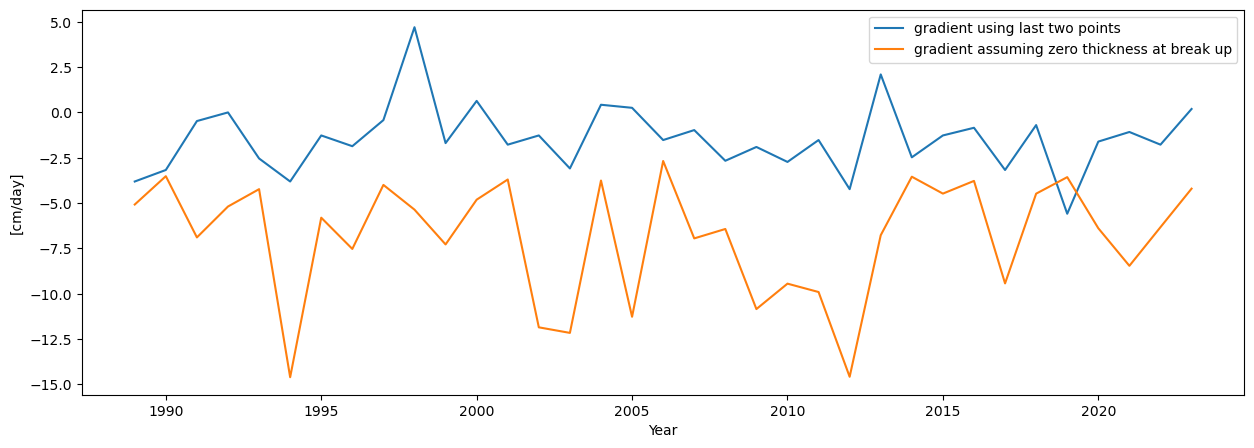

In [9]:
plt.figure(figsize=(15,5))
plt.plot(dates['last_ice_measurement'],label='last ice measurment')
plt.plot(dates['max_ice_thickness'],label='max ice thickeness')
plt.ylabel('[cm]')
plt.xlabel('year')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(dates['final_melting_gradient[cm/day]'],label='gradient using last two points')
plt.plot(dates['melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]'],label='gradient assuming zero thickness at break up')
plt.ylabel('[cm/day]')
plt.xlabel('Year')
plt.legend()

## Other Scater/TimeSeries plots

For scatter plot that use more than one value per year per variable, revert to using `plot_contents`, as we pass any column to use as xaxis.

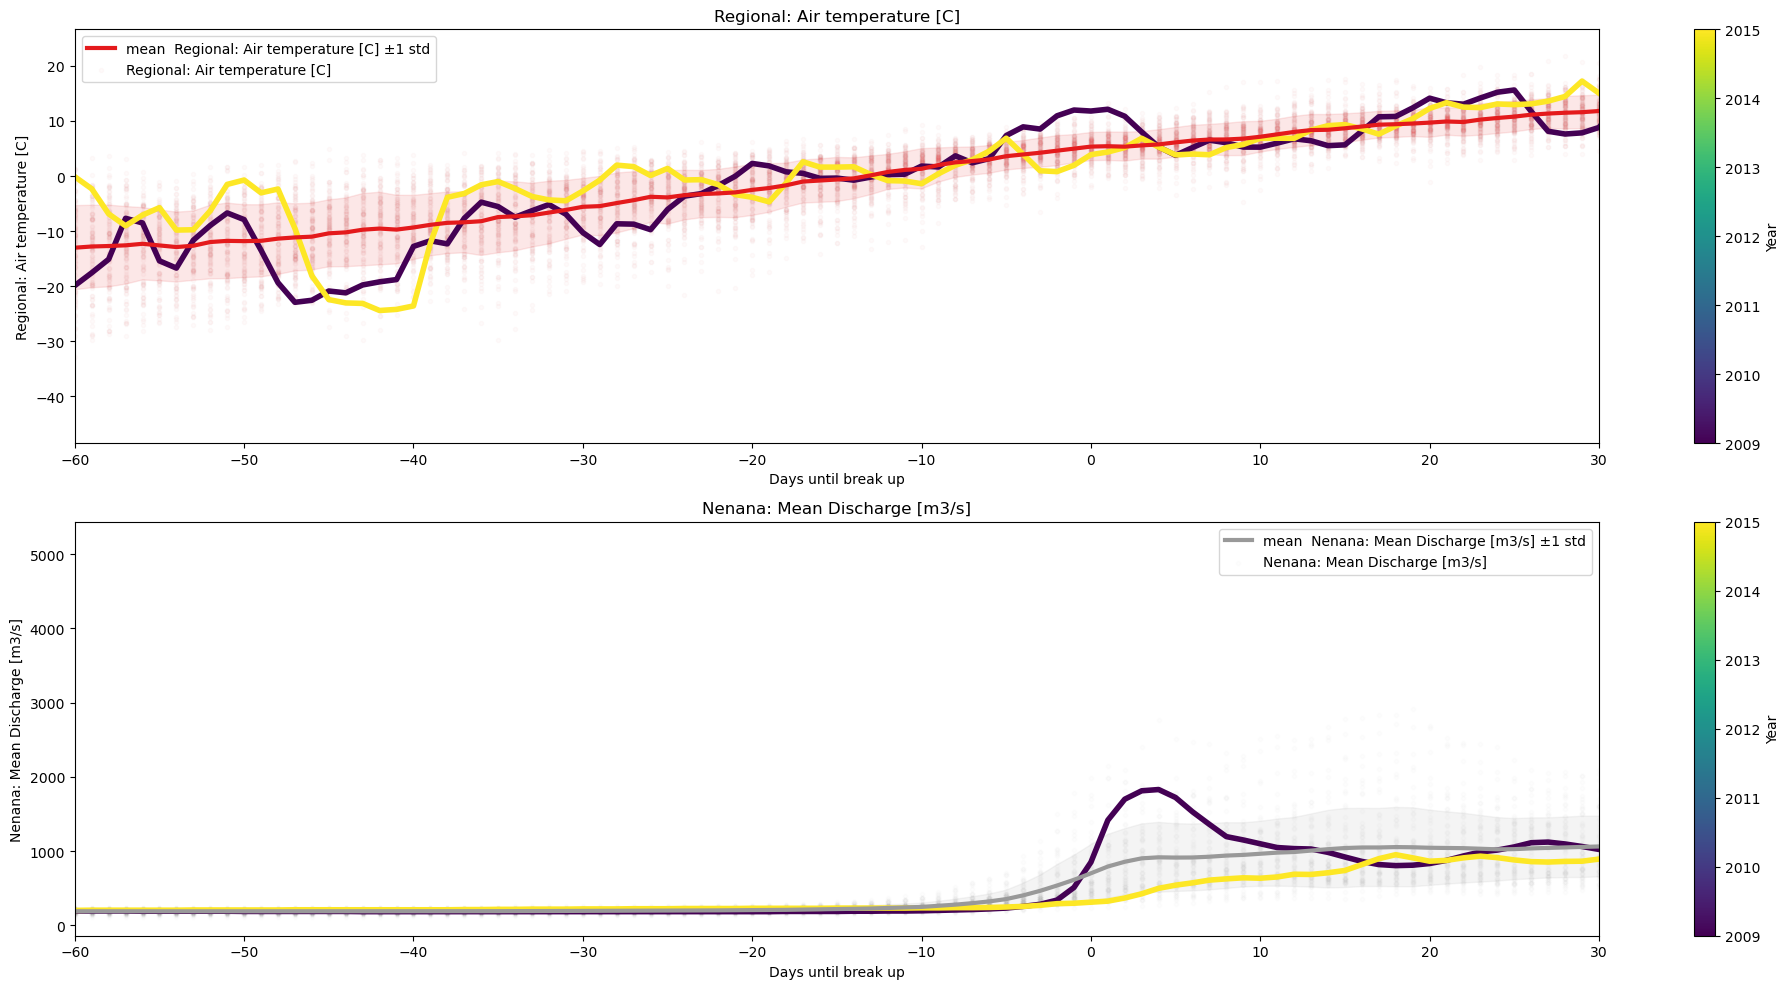

In [10]:
selected_years = [2009,2015]
plot_contents(Data,
              multiyear=selected_years,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],
              xaxis='Days until break up',
              xlim=[-60,30],
              plot_mean_std='true',
              scatter_alpha=.02,
              std_alpha=.1) 

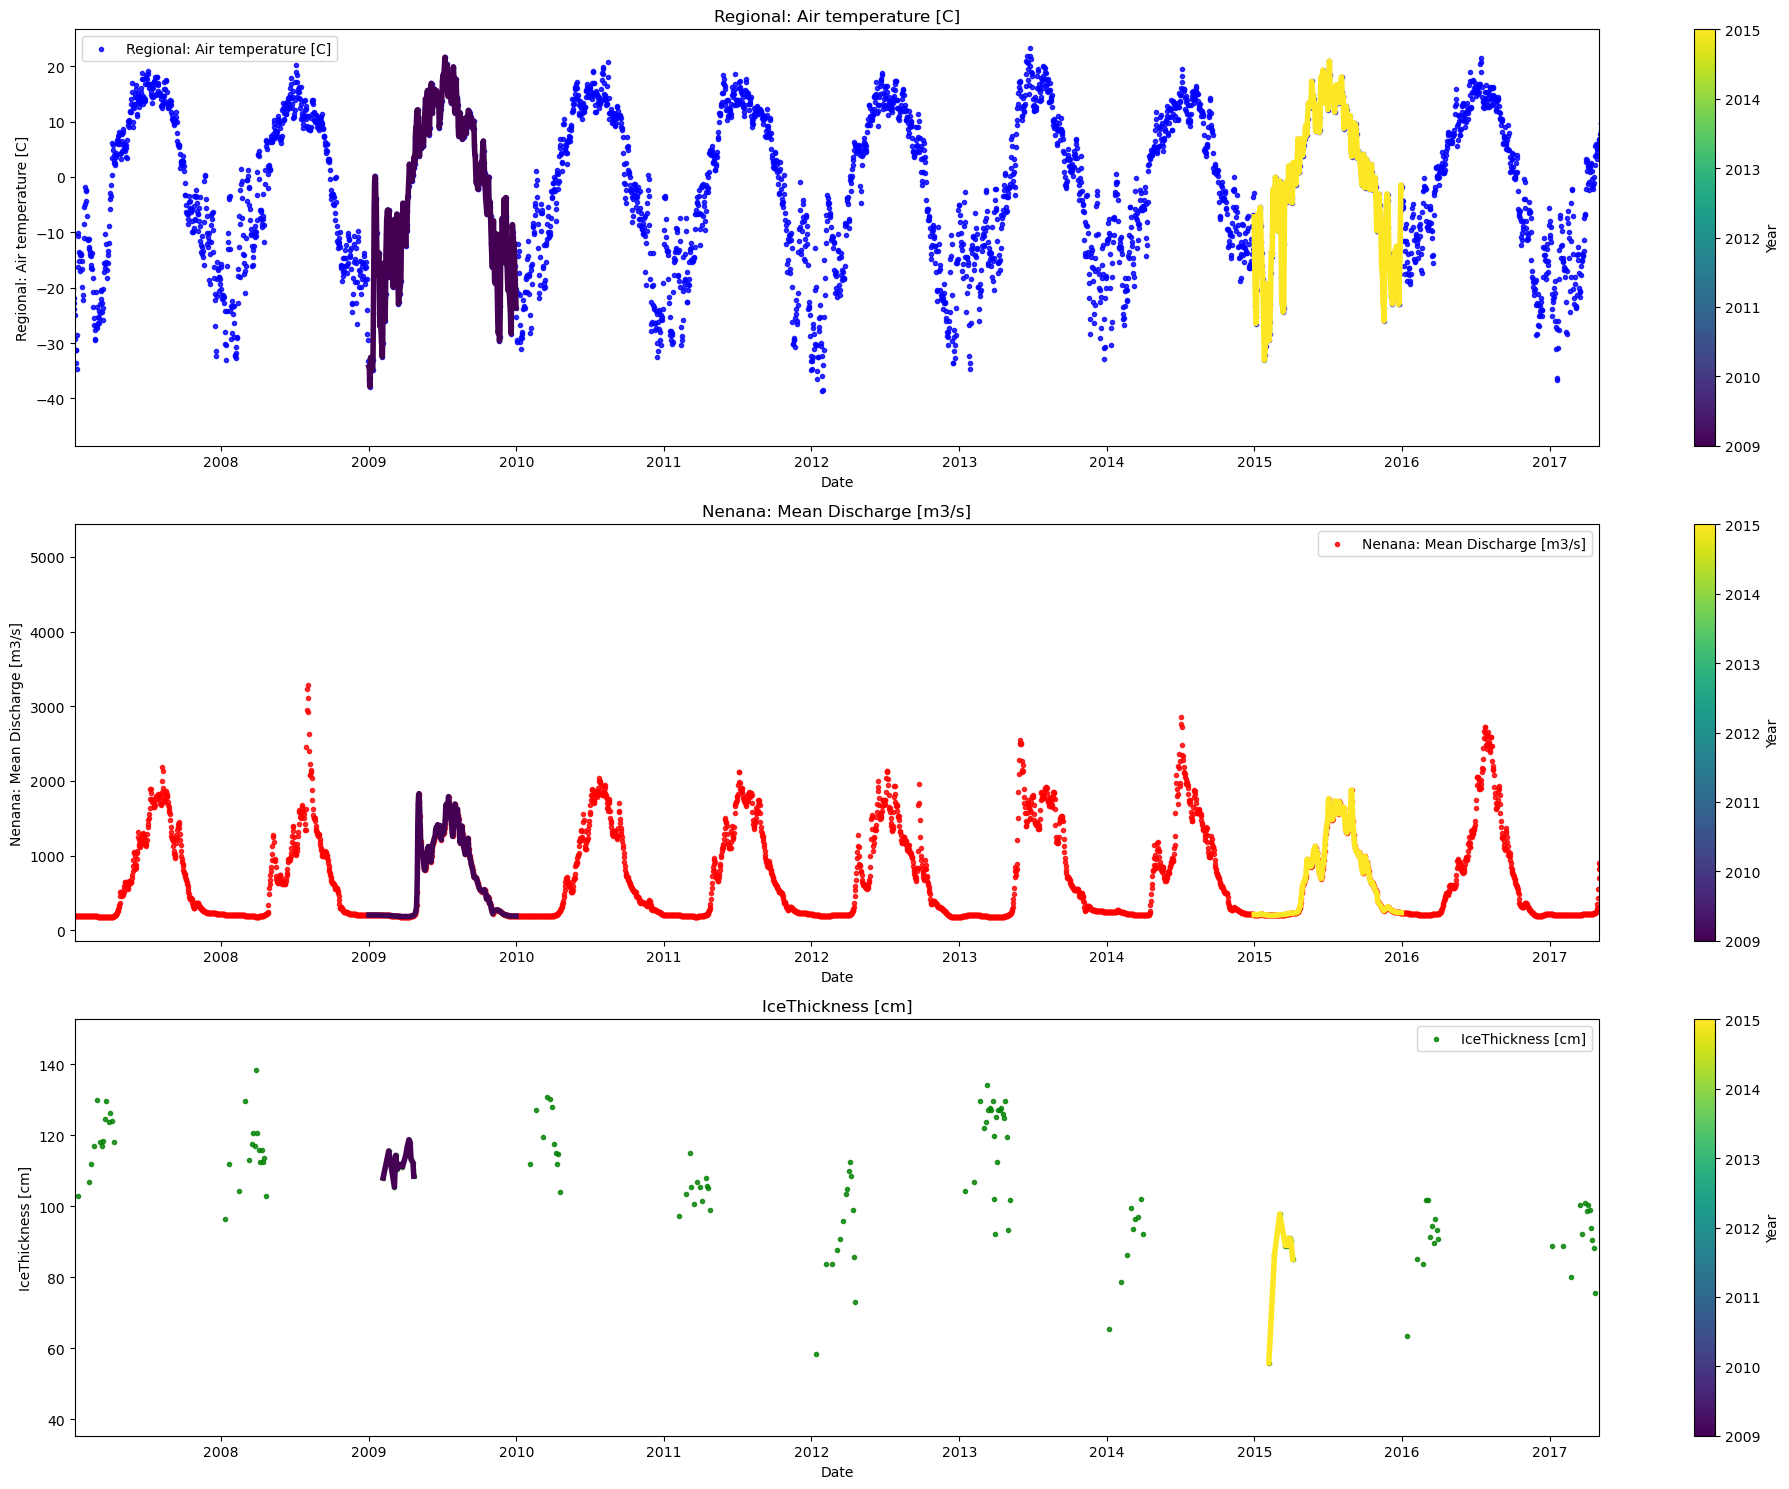

In [11]:
plot_contents(Data,
              multiyear=selected_years,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]','IceThickness [cm]'],
              xaxis='index',
              scatter_alpha=0.8,
              col_cmap=['blue','red','green'],
              xlim=['2007/01/04','2017/05/03']) 

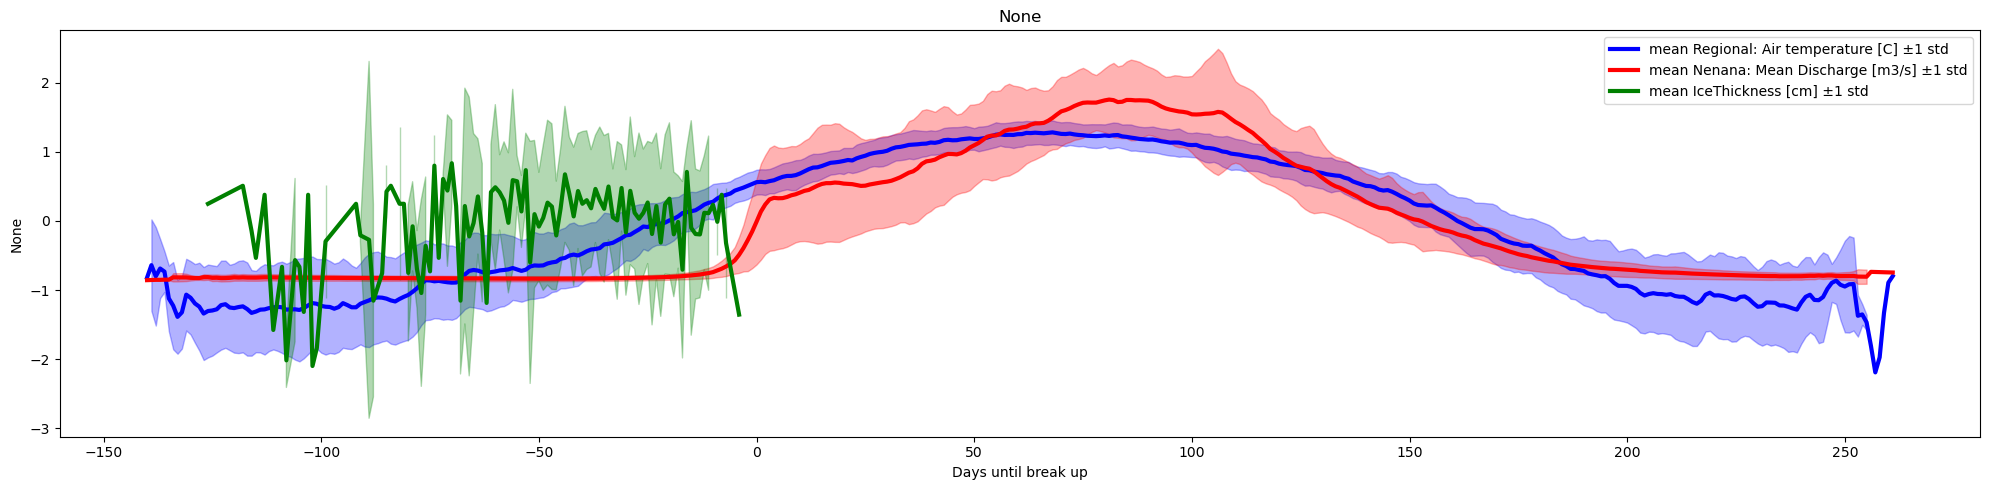

In [12]:
plot_contents(Data,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]','IceThickness [cm]'],
              plot_together=True,
              plot_mean_std='only',
              k=1,normalize='z-score',
              xaxis='Days until break up',col_cmap=['blue','red','green'])

The `IceThickness [cm]` observations are relatively sparse ( ~10 per year), and are measured at different dates each year, therefore the plot considering the mean and std associated with the aggregated data (for each date) is not an accurate representation. We can fix this  issue by interpolating the ice thickness (we assume ice start to grow on oct-15)

In [13]:
date = pd.Timestamp('2024-10-15') 
oct_15 = date.dayofyear 
Data.loc[(Data.index.dayofyear == oct_15), 'IceThickness [cm]'] = 0
Data.loc[(Data['Days until break up'] == 0), 'IceThickness [cm]'] = 0
ICE_pchip=Data['IceThickness [cm]'].interpolate(method='pchip')
ICE_pchip = ICE_pchip.clip(lower=0)

df_merged['Ice Thickness [cm]']=ICE_pchip

lets visually check the interpolation.

In [14]:
# plt.figure(figsize=(15,5))
# plt.scatter(Data.index,Data['IceThickness [cm]'],label='Original data',color='purple')
# plt.plot(Data.index,Data['Interpolated_IceThickness [cm]'],label='Interpolated data',color='orange')
# plt.xlim(pd.to_datetime(['1987/01/01','2024/01/01']))

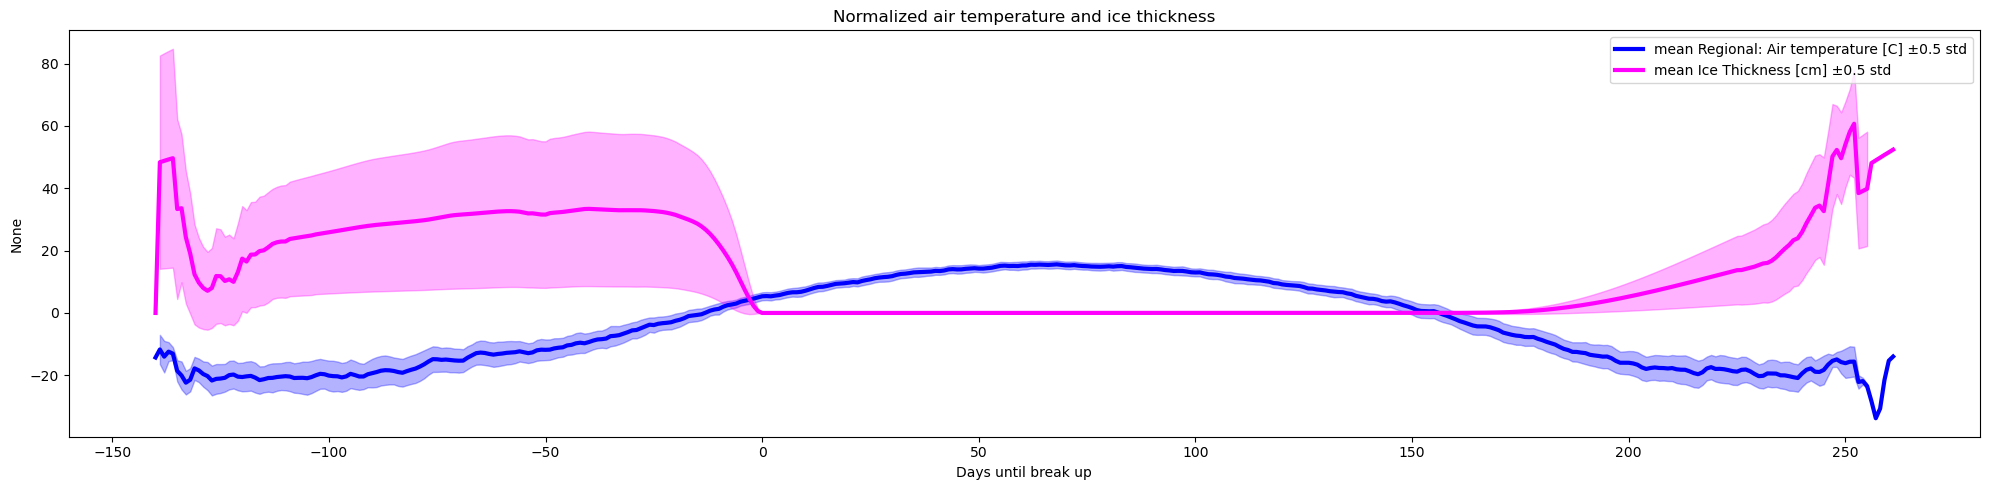

In [15]:
plot_contents(df_merged,
              columns_to_plot=['Regional: Air temperature [C]','Ice Thickness [cm]'],
              plot_together=True,
              plot_mean_std='only',
              k=0.5,
              xaxis='Days until break up',col_cmap=['blue','magenta'],
              Title='Normalized air temperature and ice thickness')

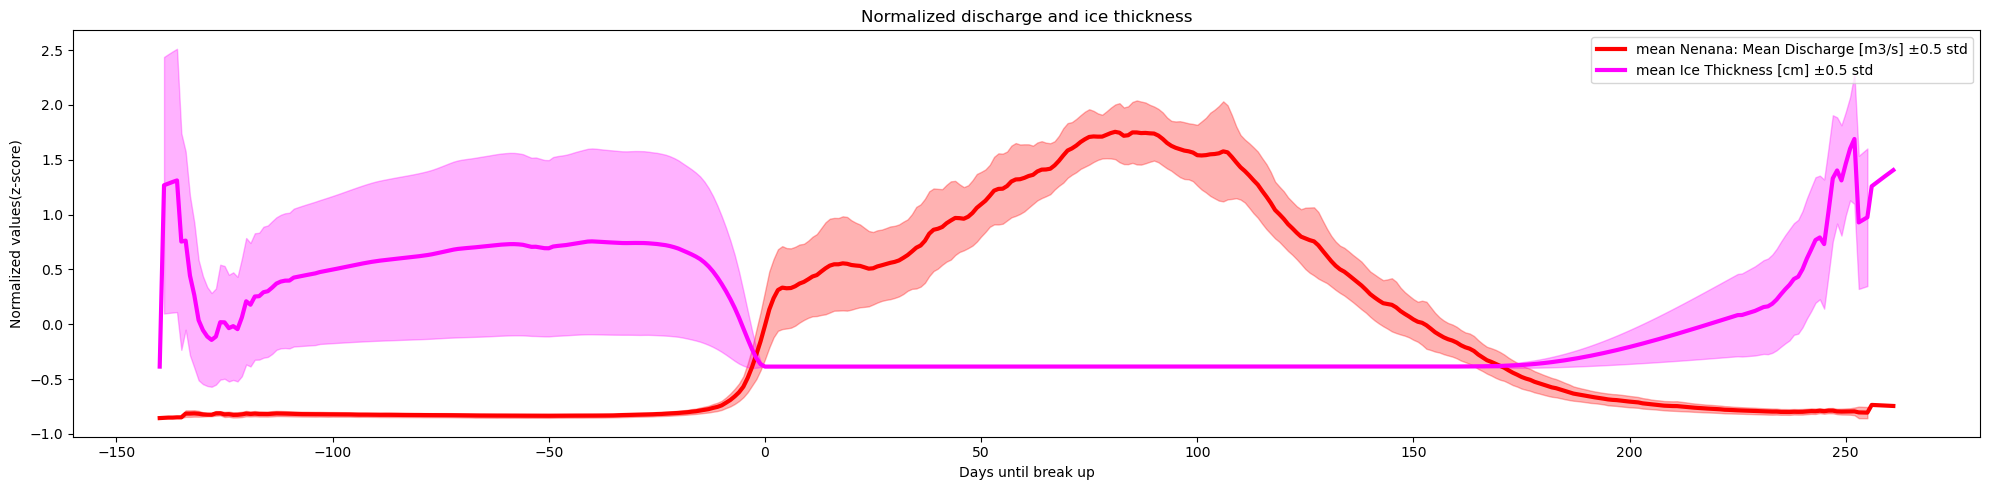

In [16]:
plot_contents(df_merged,
              columns_to_plot=['Nenana: Mean Discharge [m3/s]','Ice Thickness [cm]'],
              plot_together=True,
              plot_mean_std='only',
              k=0.5,normalize='z-score',
              xaxis='Days until break up',col_cmap=['red','magenta','magenta'],
              Title='Normalized discharge and ice thickness',
              y_label='Normalized values(z-score)')

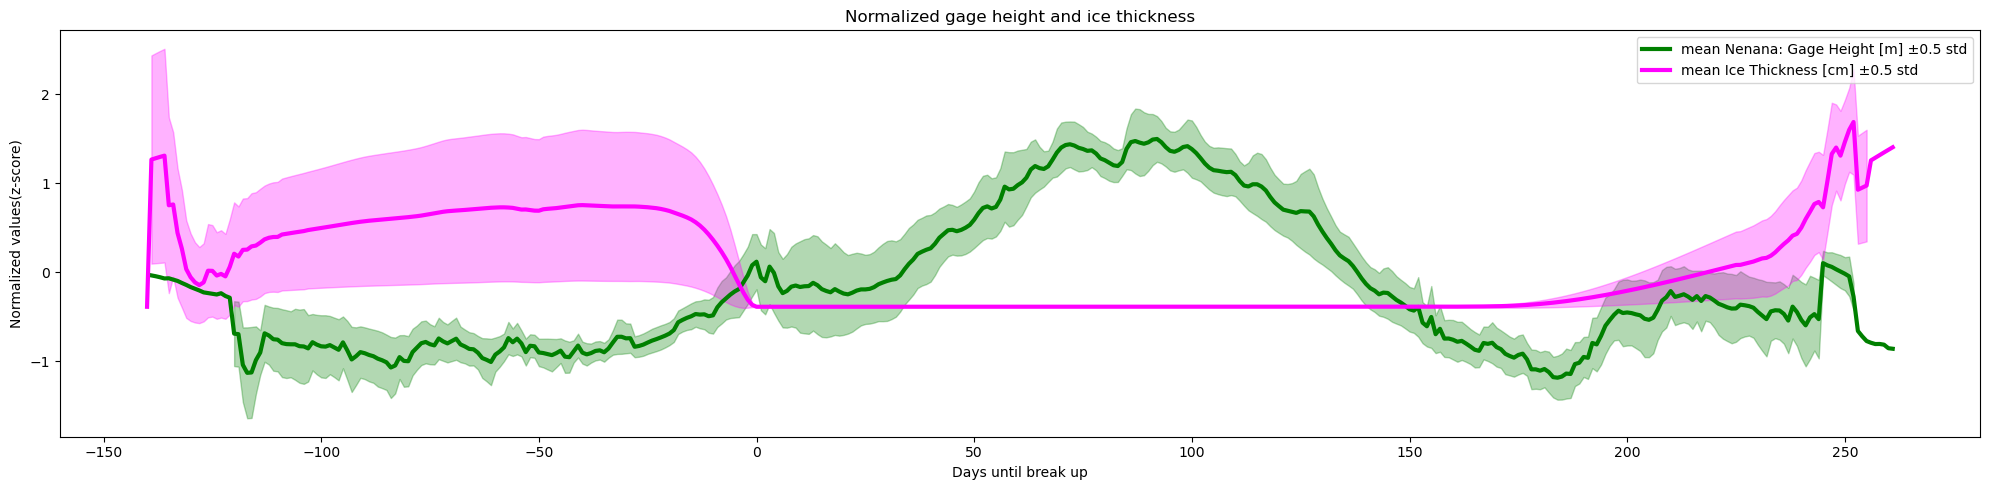

In [17]:
plot_contents(df_merged,
              columns_to_plot=['Nenana: Gage Height [m]', 'Ice Thickness [cm]'],
              plot_together=True,
              plot_mean_std='only',
              k=0.5,normalize='z-score',
              xaxis='Days until break up',col_cmap=['green','magenta'],
              Title='Normalized gage height and ice thickness',
              y_label='Normalized values(z-score)')

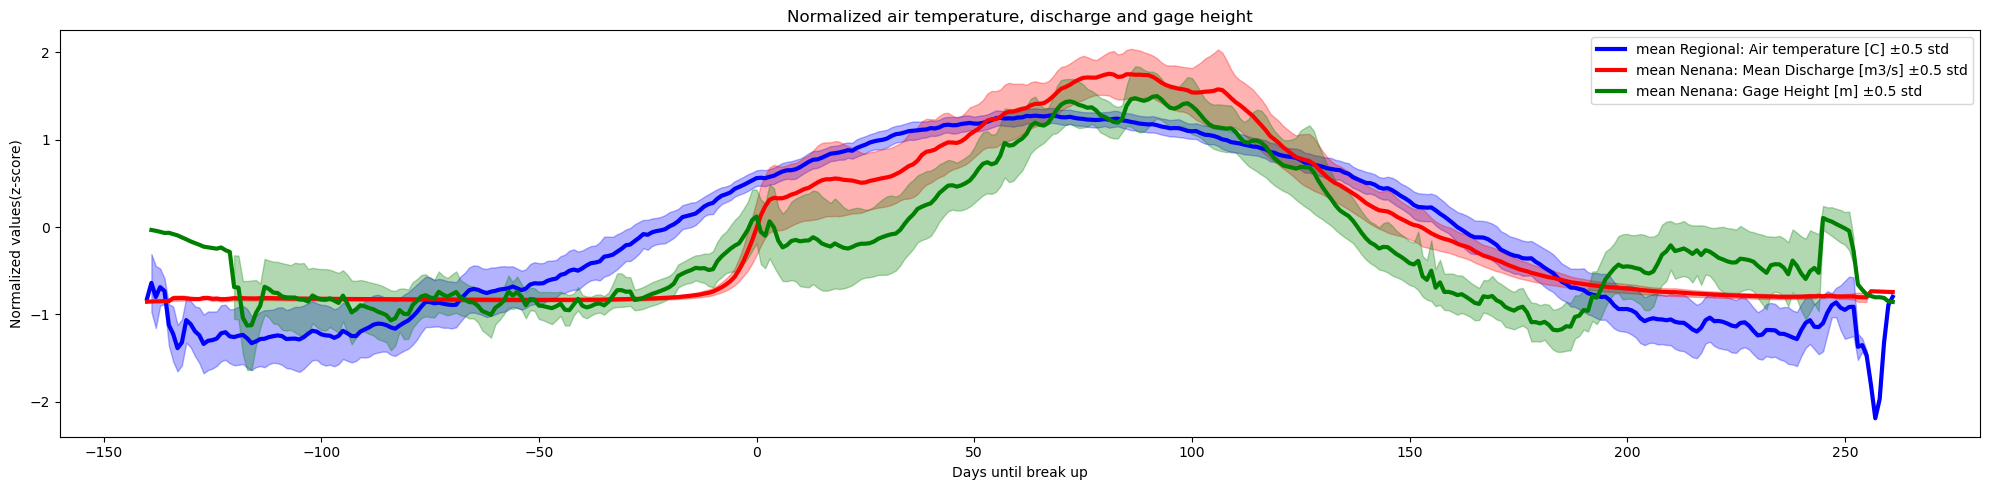

In [18]:
plot_contents(df_merged,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]','Nenana: Gage Height [m]'],
              plot_together=True,
              plot_mean_std='only',
              k=0.5,normalize='z-score',
              xaxis='Days until break up',col_cmap=['blue','red','green'],
              Title='Normalized air temperature, discharge and gage height',
              y_label='Normalized values(z-score)')

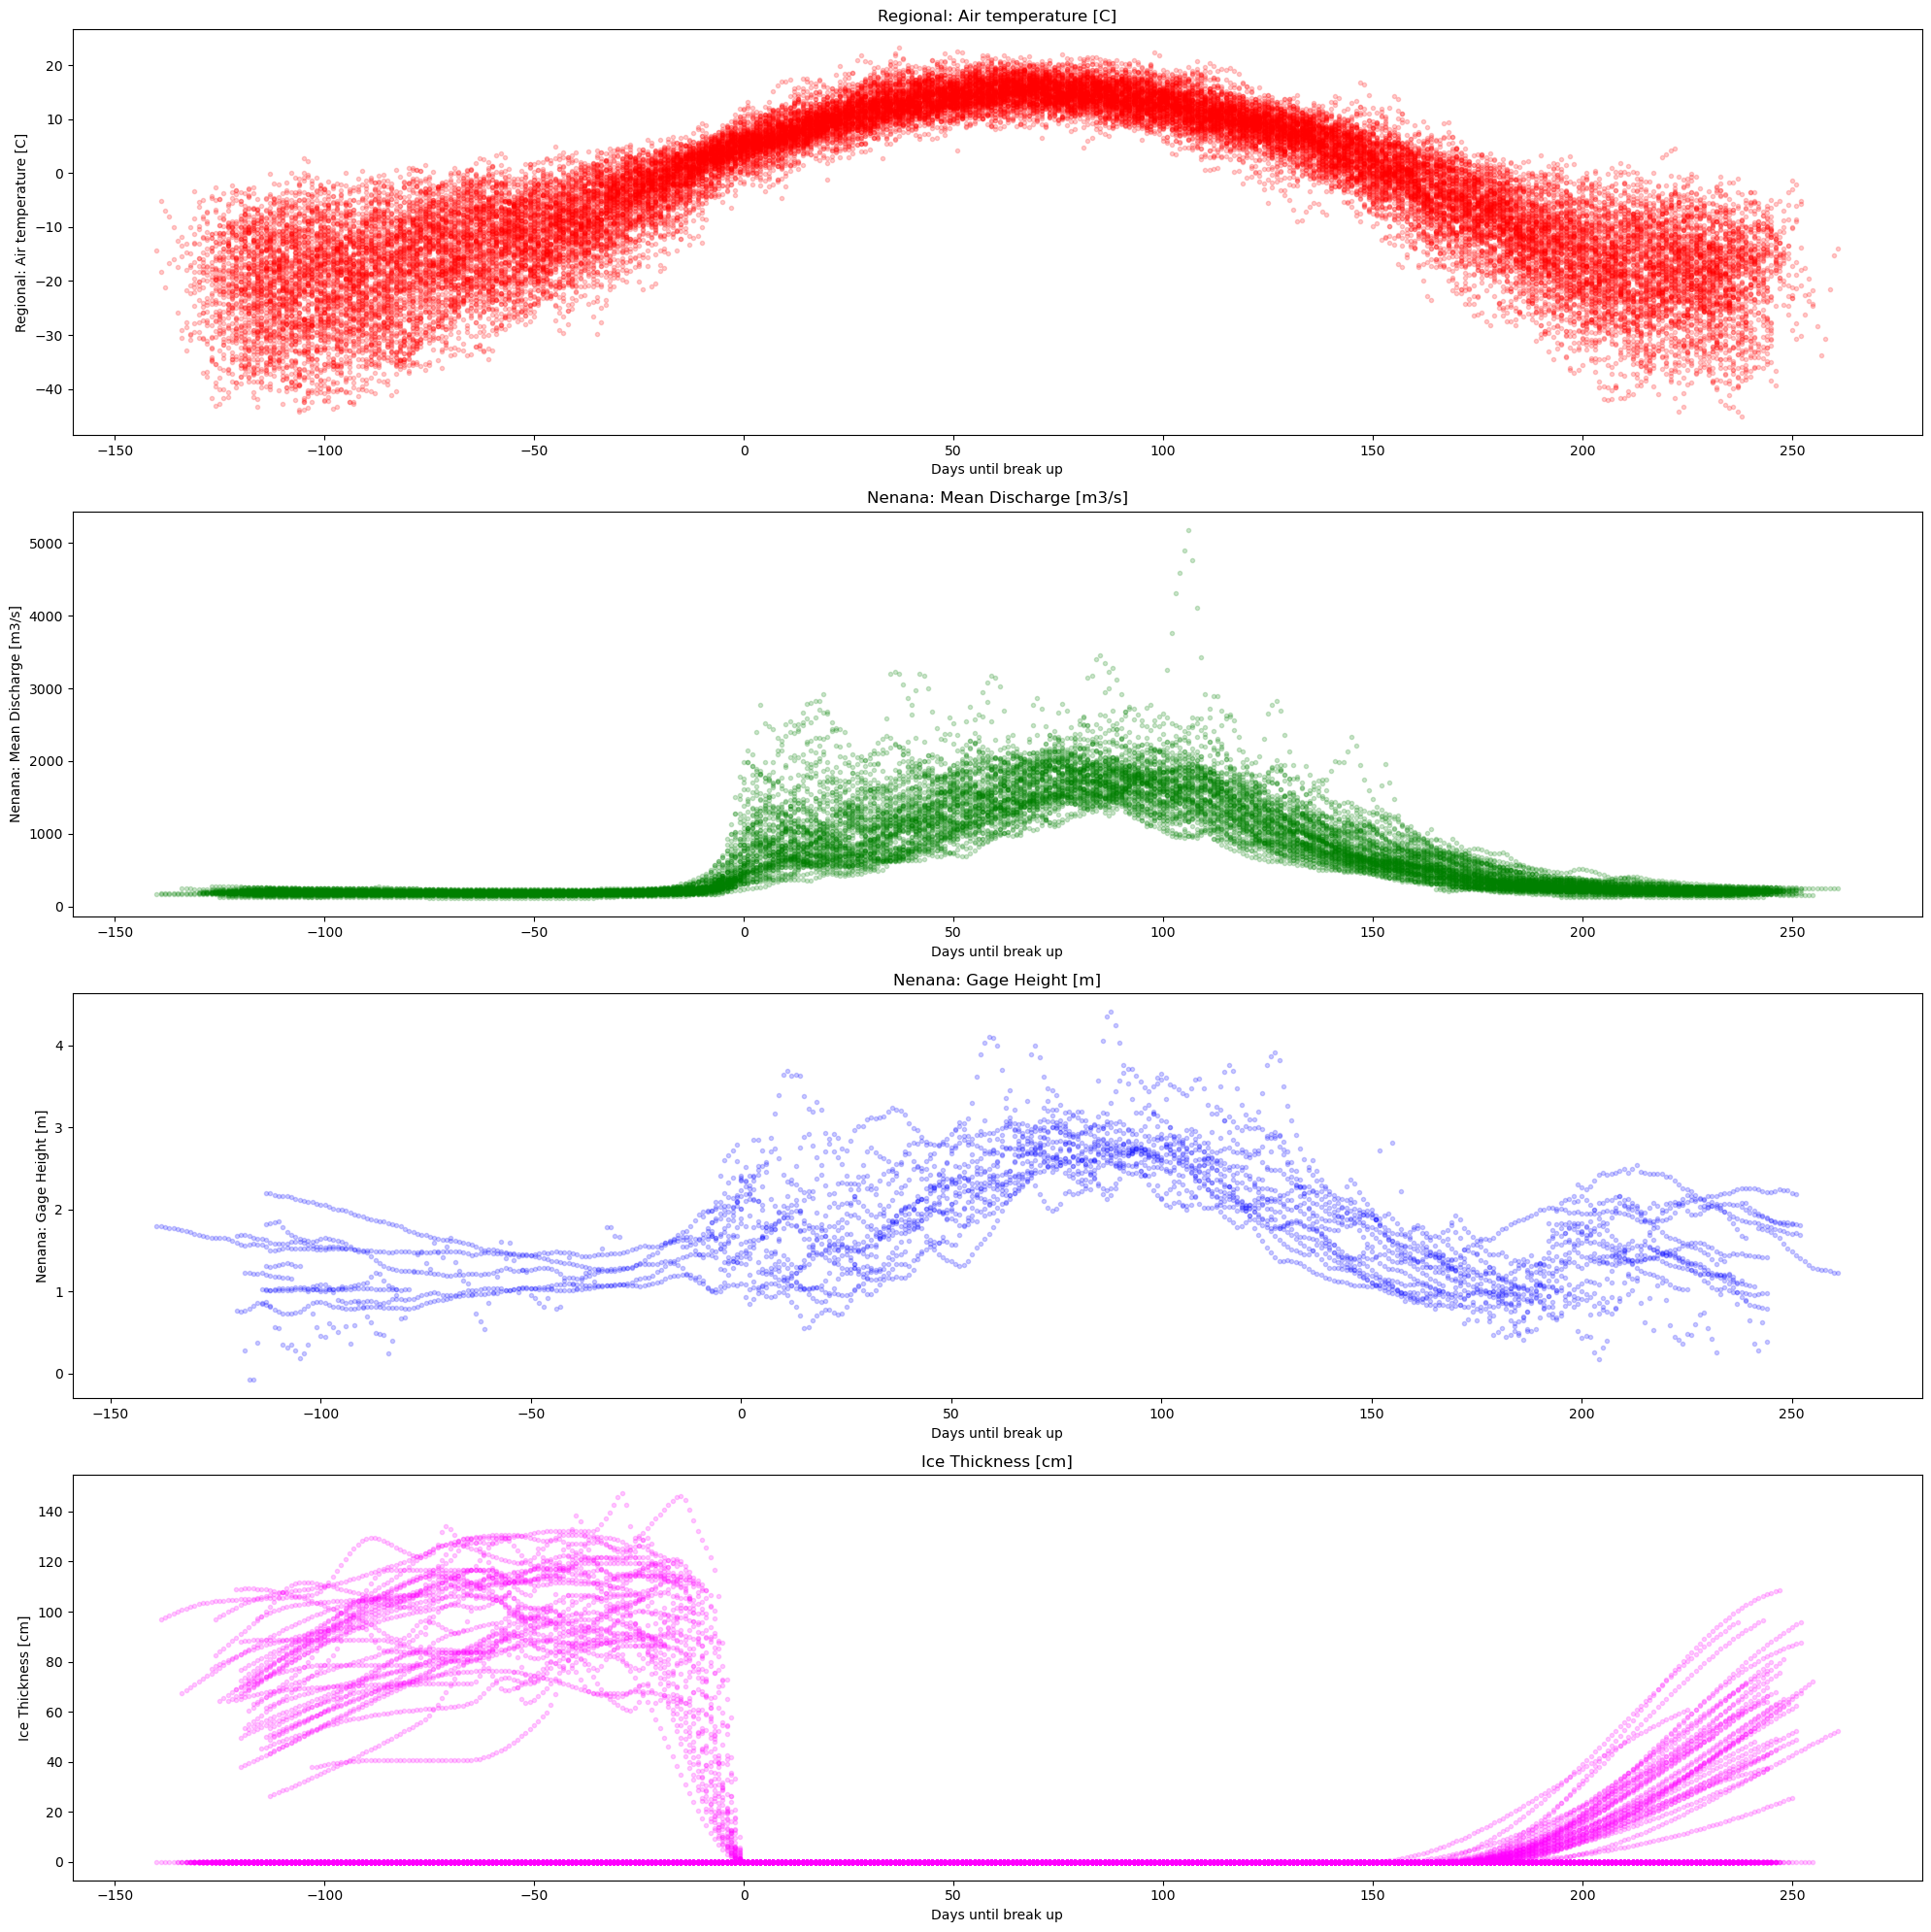

In [19]:


# # we reload df cuz we need some column that we dropped at the beginning
# Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
# Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
# Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 
# Data.info()

plot_contents(df_merged,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]','Nenana: Gage Height [m]','Ice Thickness [cm]'],     # what columns to plot, default all
              col_cmap=['red','green','blue','magenta'],                                     # list of colors for each column, default is sequential cmap, but list of colors can be passed as well
              scatter_alpha=0.2,                                     # we can 'mute' the scatter points if we choose lapha=0, then the col_map is irrelevant, cuz the scatter markers are no being plotted
              plot_mean_std=False,
            xaxis='Days until break up'   ,                                # we 'mute' the baseline across all years, similar here, if it were 'True' the color would have been grey' 
              multiyear=None,                            # we select which years to highlight
              years_line_width=2,                                    # change the iwth of line if necessary
              plot_break_up_dates=False) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39081 entries, 1917-01-01 to 2023-12-31
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29516 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22525 non-null  float64
 8   Nenana: Air temperature [C]                        31146 non-null  fl

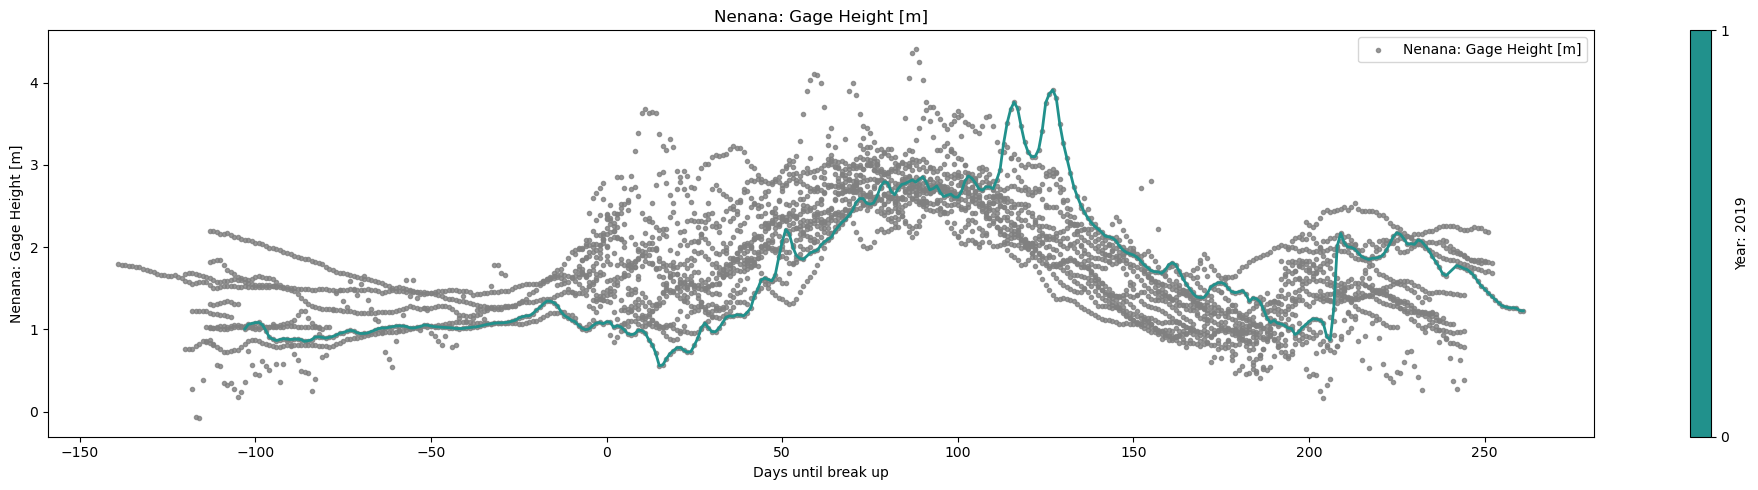

In [20]:


# we reload df cuz we need some column that we dropped at the beginning
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 
Data.info()

plot_contents(df_merged,
              columns_to_plot=['Nenana: Gage Height [m]'],     # what columns to plot, default all
              col_cmap=['grey'],                                     # list of colors for each column, default is sequential cmap, but list of colors can be passed as well
              scatter_alpha=0.8,                                     # we can 'mute' the scatter points if we choose lapha=0, then the col_map is irrelevant, cuz the scatter markers are no being plotted
              plot_mean_std=False,                                   # we 'mute' the baseline across all years, similar here, if it were 'True' the color would have been grey' 
              multiyear=[2019],                            # we select which years to highlight
              years_line_width=2,                                    # change the iwth of line if necessary
              plot_break_up_dates=True,
              xaxis='Days until break up')                              # plotting break_up_dates makers with annotations, default =False 

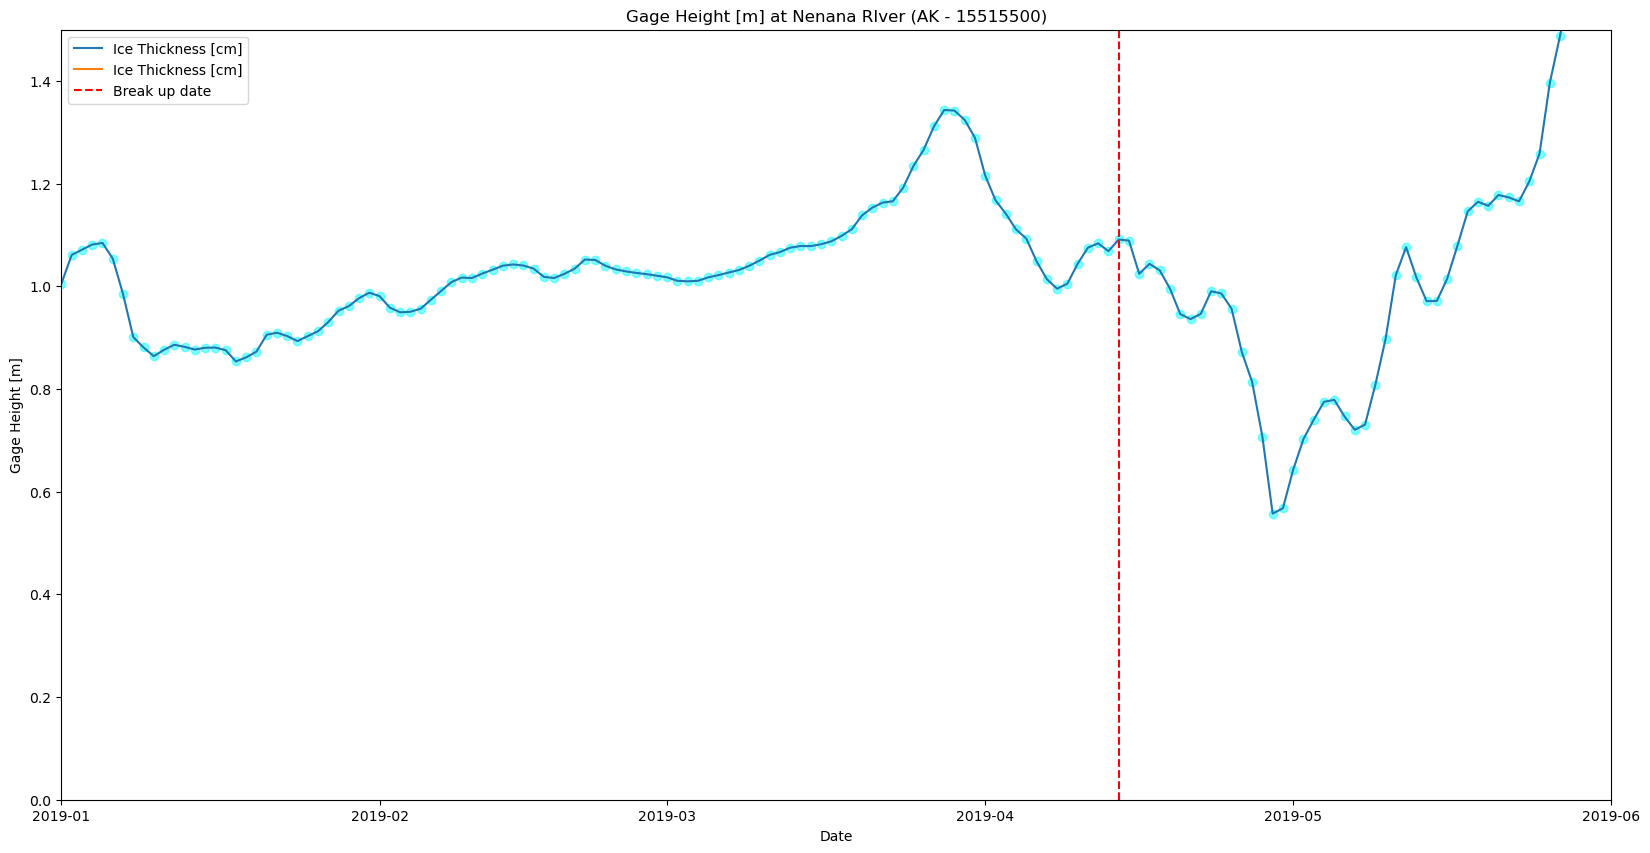

In [21]:
plt.figure(figsize=(20,10),)
plt.scatter(df_merged.index,df_merged['Nenana: Gage Height [m]'],color='cyan',marker='o',alpha=0.5)	
plt.plot(df_merged.index,df_merged['Nenana: Gage Height [m]'],label='Ice Thickness [cm]')

plt.scatter(df_merged.index,df_merged['Nenana: Mean Discharge [m3/s]'],color='orange',marker='o',alpha=0.5)	
plt.plot(df_merged.index,df_merged['Nenana: Mean Discharge [m3/s]'],label='Ice Thickness [cm]')
plt.xlim(pd.to_datetime(['2019/01/01','2019/06/01']))
plt.title('Gage Height [m] at Nenana RIver (AK - 15515500)')
plt.axvline(pd.to_datetime('2019-04-14'),color='red',linestyle='--',label='Break up date')
plt.ylim(0,1.5)
plt.xlabel('Date')
plt.ylabel('Gage Height [m]')
plt.legend()
plt.show()


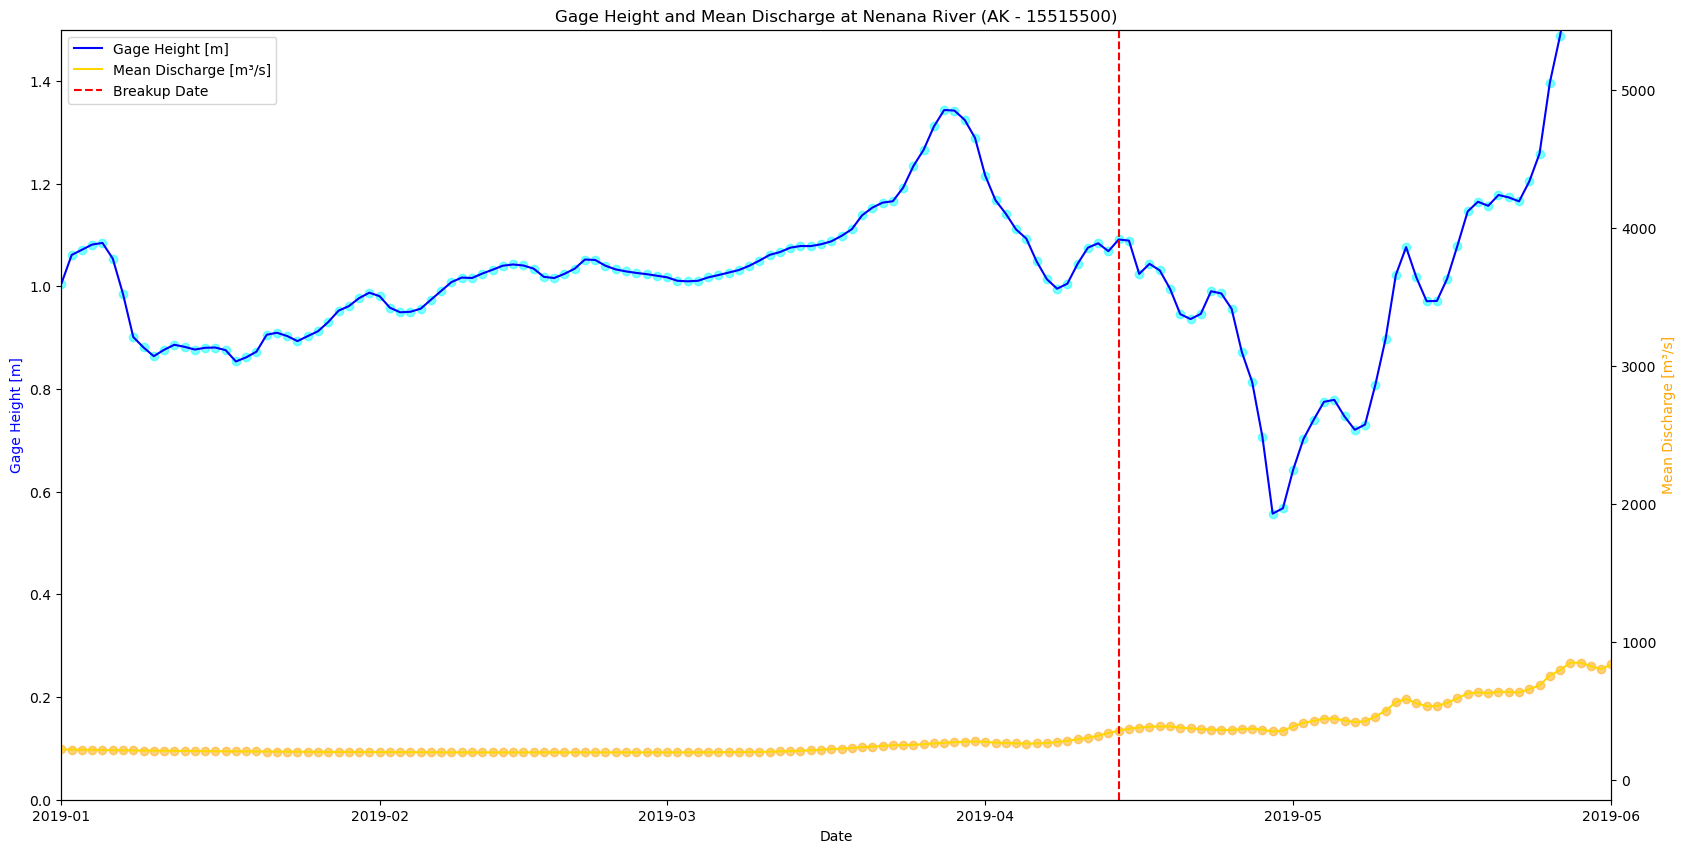

In [22]:
# Create figure and first axis
plt.figure(figsize=(20, 10))
ax1 = plt.gca()  # Get current axis

# Plot Gage Height on the first y-axis
ax1.scatter(df_merged.index, df_merged['Nenana: Gage Height [m]'], color='cyan', marker='o', alpha=0.5)
ax1.plot(df_merged.index, df_merged['Nenana: Gage Height [m]'], color='blue', label='Gage Height [m]')
ax1.set_ylabel('Gage Height [m]', color='blue')
ax1.set_ylim(0, 1.5)

# Create second y-axis for Discharge
ax2 = ax1.twinx()
ax2.scatter(df_merged.index, df_merged['Nenana: Mean Discharge [m3/s]'], color='orange', marker='o', alpha=0.5)
ax2.plot(df_merged.index, df_merged['Nenana: Mean Discharge [m3/s]'], color='gold', label='Mean Discharge [m³/s]')
ax2.set_ylabel('Mean Discharge [m³/s]', color='orange')

# Common settings
ax1.set_xlim(pd.to_datetime(['2019/01/01', '2019/06/01']))
plt.title('Gage Height and Mean Discharge at Nenana River (AK - 15515500)')
plt.axvline(pd.to_datetime('2019-04-14'), color='red', linestyle='--', label='Breakup Date')
ax1.set_xlabel('Date')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.show()


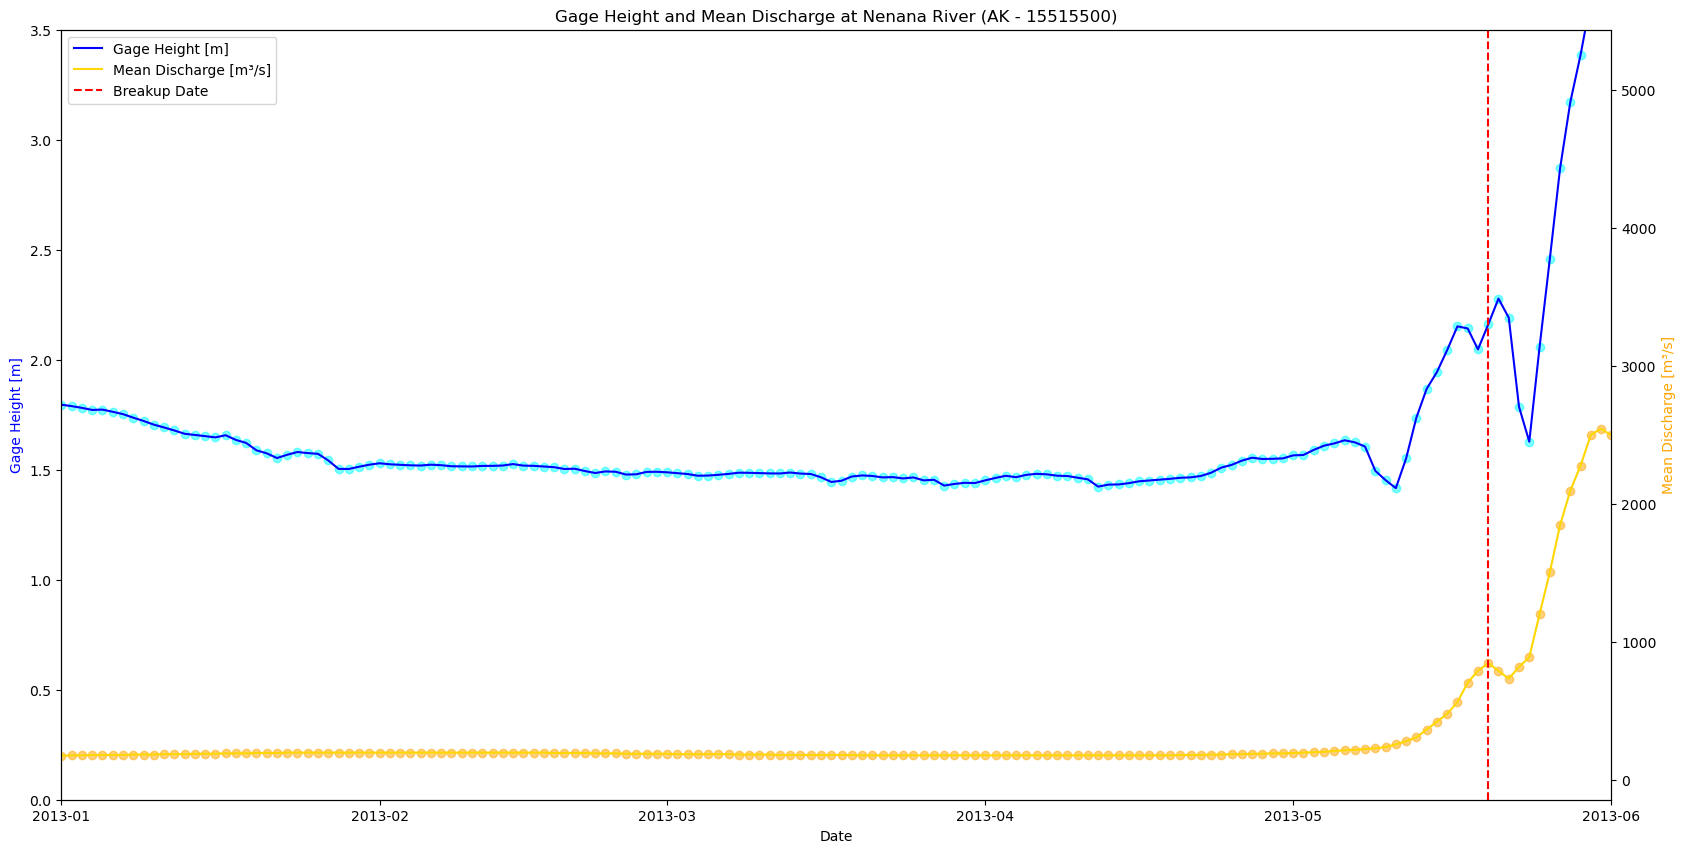

In [23]:
# Create figure and first axis
plt.figure(figsize=(20, 10))
ax1 = plt.gca()  # Get current axis

# Plot Gage Height on the first y-axis
ax1.scatter(df_merged.index, df_merged['Nenana: Gage Height [m]'], color='cyan', marker='o', alpha=0.5)
ax1.plot(df_merged.index, df_merged['Nenana: Gage Height [m]'], color='blue', label='Gage Height [m]')
ax1.set_ylabel('Gage Height [m]', color='blue')
ax1.set_ylim(0, 3.5)

# Create second y-axis for Discharge
ax2 = ax1.twinx()
ax2.scatter(df_merged.index, df_merged['Nenana: Mean Discharge [m3/s]'], color='orange', marker='o', alpha=0.5)
ax2.plot(df_merged.index, df_merged['Nenana: Mean Discharge [m3/s]'], color='gold', label='Mean Discharge [m³/s]')
ax2.set_ylabel('Mean Discharge [m³/s]', color='orange')

# Common settings
ax1.set_xlim(pd.to_datetime(['2013/01/01', '2013/06/01']))
plt.title('Gage Height and Mean Discharge at Nenana River (AK - 15515500)')
plt.axvline(pd.to_datetime('2013-05-20'), color='red', linestyle='--', label='Breakup Date')
ax1.set_xlabel('Date')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.show()

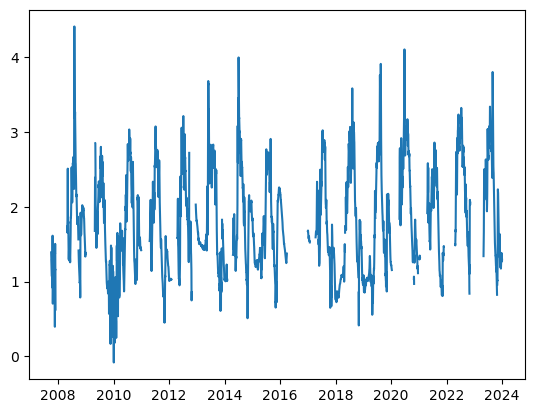

In [24]:
mask_2009 = (df_merged.index >= '2016-04-01') & (df_merged.index <= '2016-12-31')
df_merged.loc[mask_2009, 'Regional: Air temperature [C]'] = pd.NA
df_merged.loc[mask_2009, 'Nenana: Gage Height [m]'] = pd.NA
df_merged.loc[mask_2009, 'Nenana: Mean Discharge [m3/s]'] = pd.NA


plt.plot(df_merged['Nenana: Gage Height [m]'], label='Regional: Air temperature [C]')


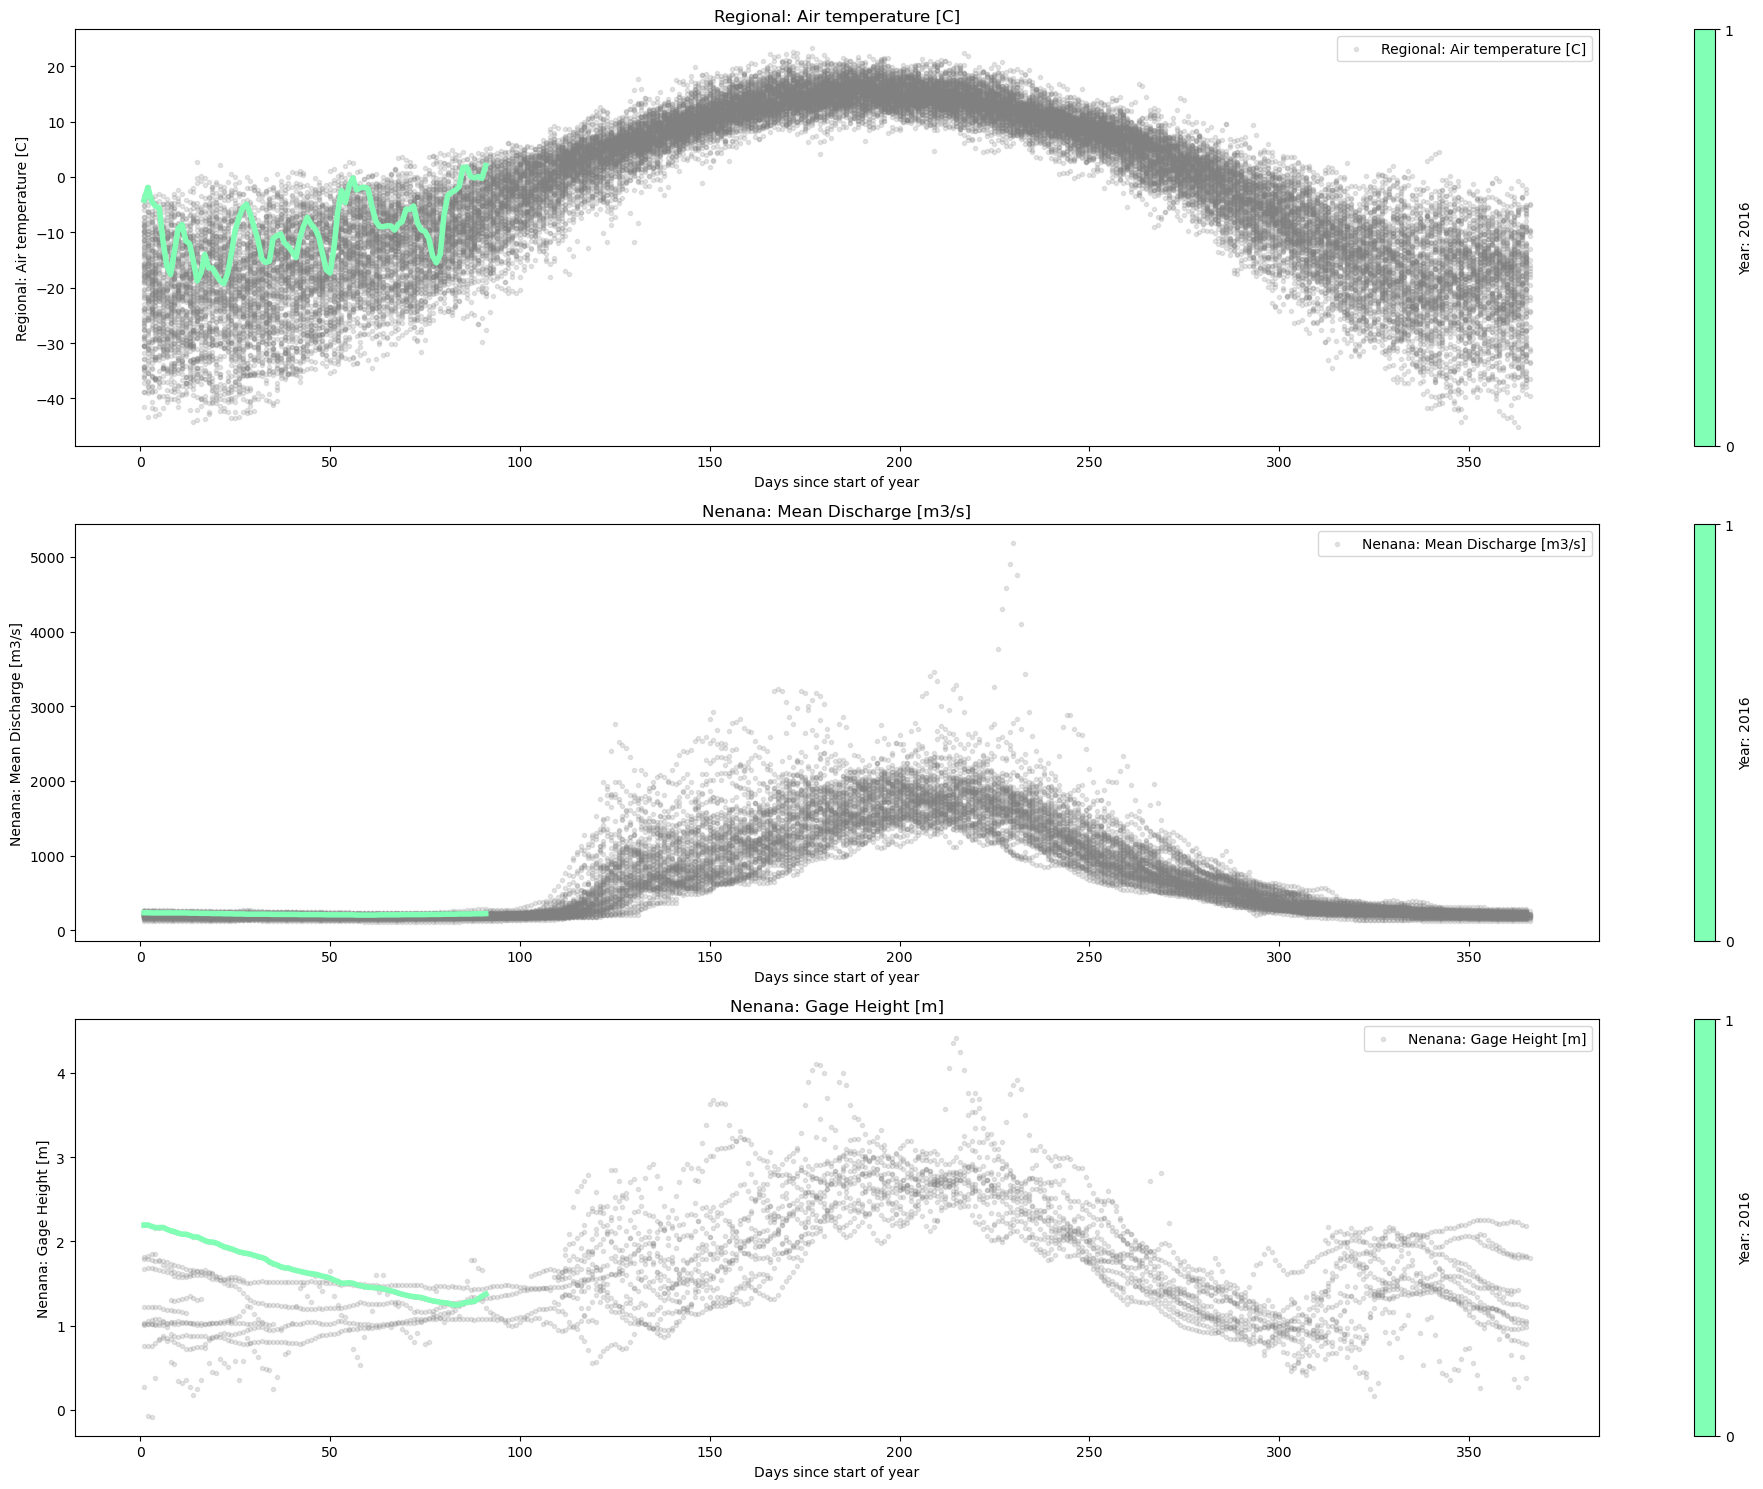

In [25]:
plot_contents(df_merged,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]','Nenana: Gage Height [m]'],     # what columns to plot, default all
              col_cmap=['grey'],                                     # list of colors for each column, default is sequential cmap, but list of colors can be passed as well
              scatter_alpha=0.2,                                     # we can 'mute' the scatter points if we choose lapha=0, then the col_map is irrelevant, cuz the scatter markers are no being plotted
              plot_mean_std=False,                                   # we 'mute' the baseline across all years, similar here, if it were 'True' the color would have been grey' 
              multiyear=[2016],                            # we select which years to highlight
              years_line_width=4,                                    # change the iwth of line if necessary
              plot_break_up_dates=False,
              years_cmap='rainbow')                              # plotting break_up_dates makers with annotations, default =Fals)  

In [26]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39081 entries, 1917-01-01 to 2023-12-31
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29516 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22525 non-null  float64
 8   Nenana: Air temperature [C]                        31146 non-null  fl

C:\Users\gabri\AppData\Local\Temp\ipykernel_27920\164860991.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2013['Month-Day'] = df_2013.index.strftime('%m-%d')
C:\Users\gabri\AppData\Local\Temp\ipykernel_27920\164860991.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['Month-Day'] = df_2019.index.strftime('%m-%d')


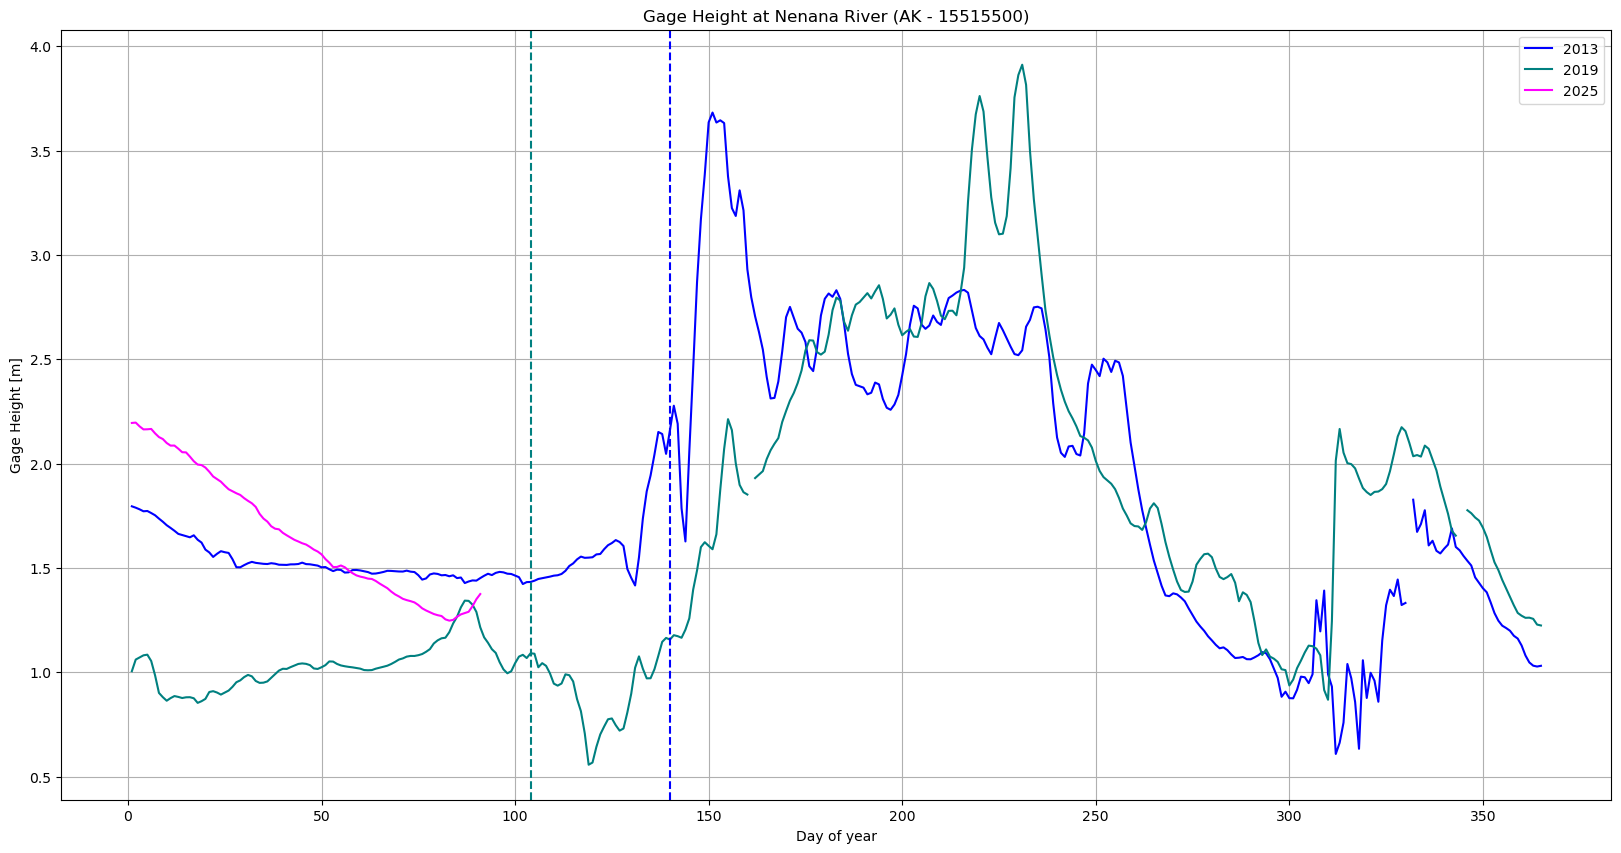

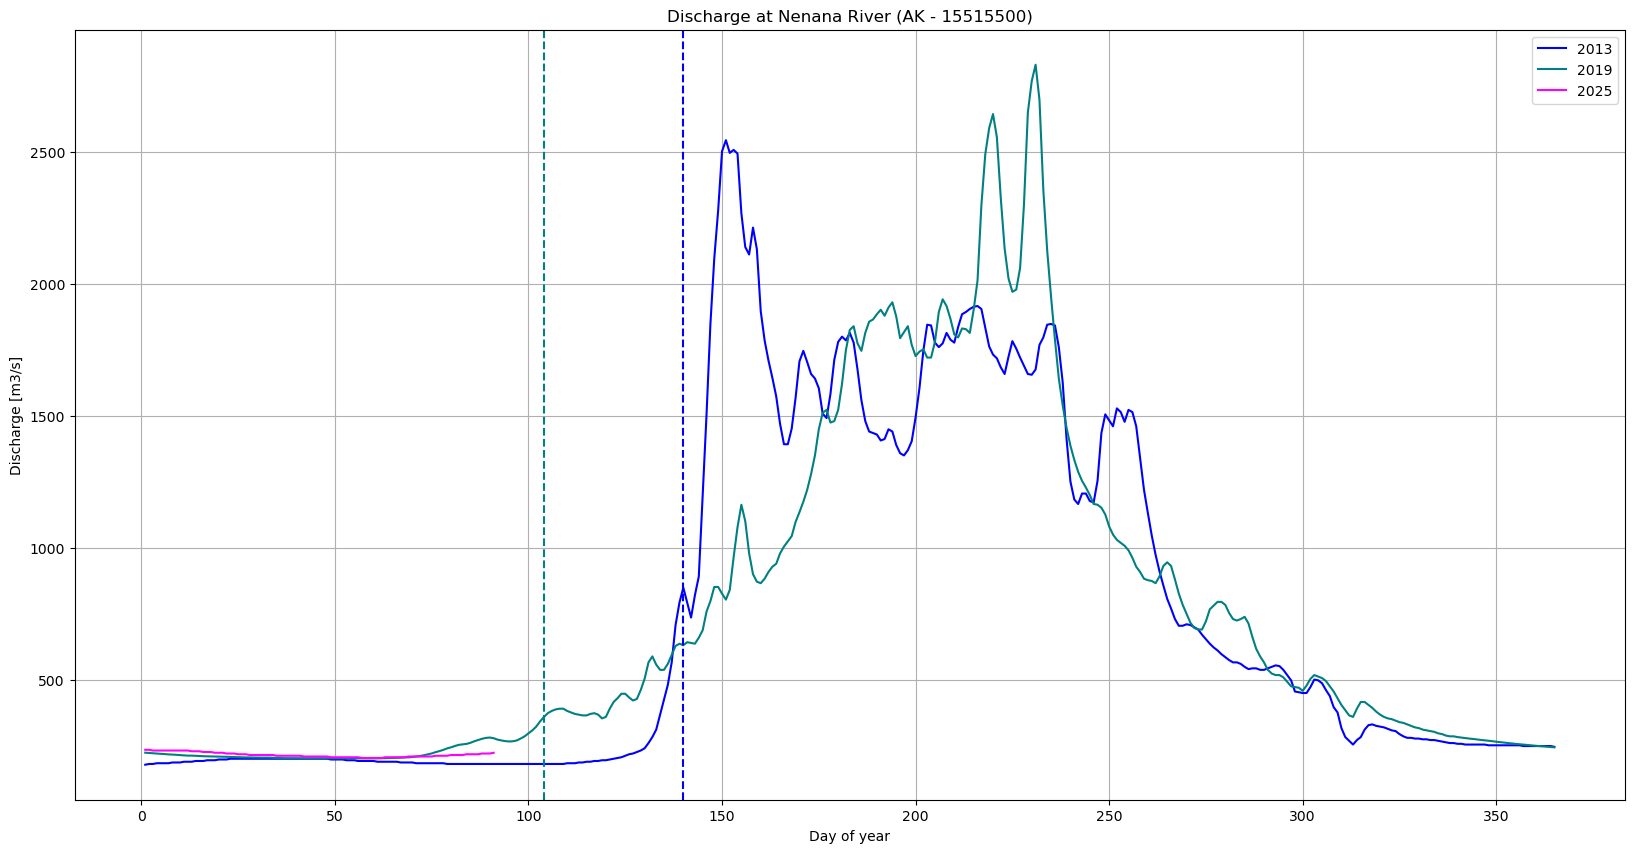

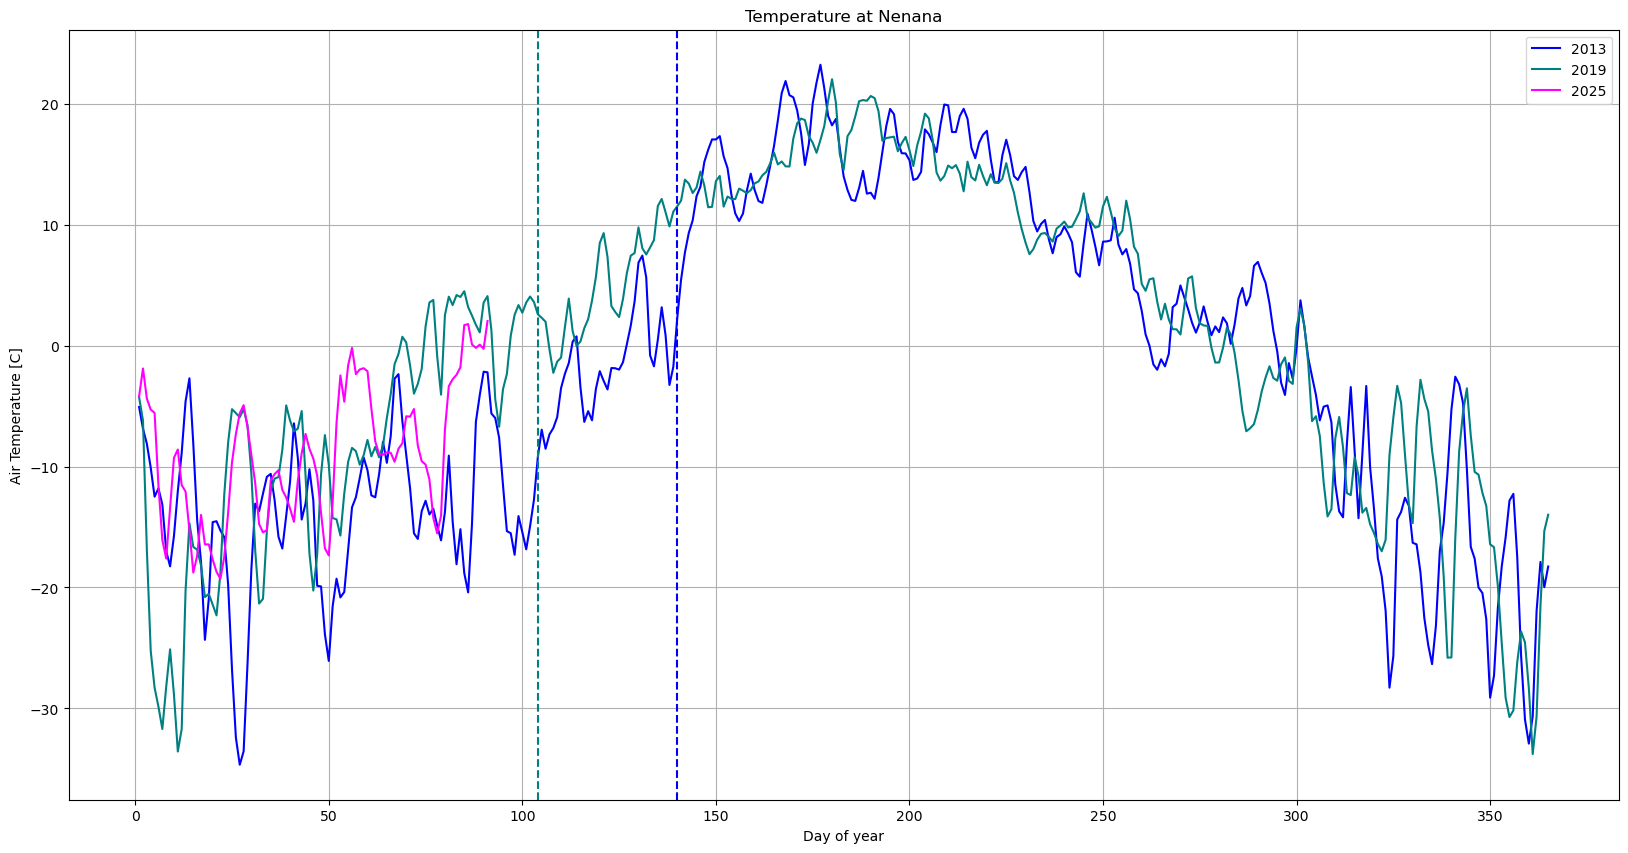

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter data for 2013 and 2019
df_2013 = df_merged[df_merged.index.year == 2013]
df_2019 = df_merged[df_merged.index.year == 2019]
df_2011 = df_merged[df_merged.index.year == 2016]

# Extract Month-Day format for the x-axis
df_2013['Month-Day'] = df_2013.index.strftime('%m-%d')
df_2019['Month-Day'] = df_2019.index.strftime('%m-%d')

# Create figure and first axis
plt.figure(figsize=(20, 10))

# Plot Gage Height on the first y-axis
plt.plot(df_2013['Days since start of year'], df_2013['Nenana: Gage Height [m]'], color='blue', label='2013')
plt.plot(df_2019['Days since start of year'], df_2019['Nenana: Gage Height [m]'], color='teal', label='2019')
plt.plot(df_2011['Days since start of year'], df_2011['Nenana: Gage Height [m]'], color='magenta', label='2025')
plt.axvline(pd.to_datetime('2019-04-14').dayofyear,color='teal',linestyle='--')
plt.axvline(pd.to_datetime('2013-05-20').dayofyear,color='blue',linestyle='--')
plt.xlabel('Day of year')
# Common settings
plt.title('Gage Height at Nenana River (AK - 15515500)')
plt.ylabel('Gage Height [m]')
plt.grid(True)
plt.legend()
plt.show()


# Create figure and first axis
plt.figure(figsize=(20, 10))

# Plot Gage Height on the first y-axis
plt.plot(df_2013['Days since start of year'], df_2013['Nenana: Mean Discharge [m3/s]'], color='blue', label='2013')
plt.plot(df_2019['Days since start of year'], df_2019['Nenana: Mean Discharge [m3/s]'], color='teal', label='2019')
plt.plot(df_2011['Days since start of year'], df_2011['Nenana: Mean Discharge [m3/s]'], color='magenta', label='2025')
plt.axvline(pd.to_datetime('2019-04-14').dayofyear,color='teal',linestyle='--')
plt.axvline(pd.to_datetime('2013-05-20').dayofyear,color='blue',linestyle='--')
plt.xlabel('Day of year')

# Common settings
plt.title('Discharge at Nenana River (AK - 15515500)')
plt.ylabel('Discharge [m3/s]')
plt.grid(True)
plt.legend()
plt.show()

# Create figure and first axis
plt.figure(figsize=(20, 10))

# Plot Gage Height on the first y-axis
plt.plot(df_2013['Days since start of year'], df_2013['Regional: Air temperature [C]'], color='blue', label='2013')
plt.plot(df_2019['Days since start of year'], df_2019['Regional: Air temperature [C]'], color='teal', label='2019')
plt.plot(df_2011['Days since start of year'], df_2011['Regional: Air temperature [C]'], color='magenta', label='2025')
plt.axvline(pd.to_datetime('2019-04-14').dayofyear,color='teal',linestyle='--')
plt.axvline(pd.to_datetime('2013-05-20').dayofyear,color='blue',linestyle='--')
plt.xlabel('Day of year')

# Common settings
plt.title('Temperature at Nenana')
plt.ylabel('Air Temperature [C]')
plt.grid(True)
plt.legend()
plt.show()

